## **0.0** Set Up

In [1]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
from collections import Counter

## **1.0** EDA & Data Prep

### application_data.csv

In [2]:
df_application = pd.read_csv('application_data.csv')
df_application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Initial Data Cleaning

#### 1. Check Nulls and Duplicates - Overall

In [3]:
print("Number of rows:", df_application.shape[0])
print("Number of columns:", df_application.shape[1])
num_dups = df_application.duplicated().sum()
print("Number of duplicate rows:", num_dups)
num_nulls = df_application.isnull().any(axis=1).sum()
print("Number of rows with null values:", num_nulls)

Number of rows: 307511
Number of columns: 122
Number of duplicate rows: 0
Number of rows with null values: 298909


#### 2. Check target variable

In [4]:
import matplotlib.pyplot as plt

def plot_value_counts_with_percentages(data, column, figsize=(8, 5), colors=None, title=None):
    """
    Plots value counts of a specified column with percentages annotated.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column to analyze.
        figsize (tuple): Size of the plot (default: (8, 5)).
        colors (list): List of colors for the bars (default: None).
        title (str): Title of the plot (default: None).
    """
    # Get value counts and percentages
    value_counts = data[column].value_counts()
    percentages = value_counts / value_counts.sum() * 100

    # Plot the bar chart
    plt.figure(figsize=figsize)
    bars = plt.bar(value_counts.index, value_counts.values, color=colors)

    # Annotate bars with percentages
    for bar, percentage in zip(bars, percentages):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # Center of the bar
            bar.get_height() + value_counts.max() * 0.01,  # Slightly above the bar
            f'{percentage:.1f}%',              # Format percentage to 1 decimal place
            ha='center', va='bottom', fontsize=10
        )

    # Add title and labels
    plt.title(title if title else f'Distribution of {column}', fontsize=16)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0)  # Keep x-axis labels horizontal
    plt.show()

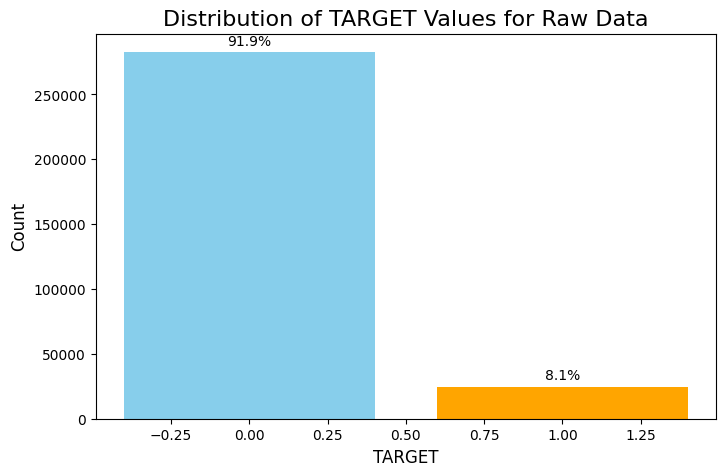

In [5]:
# check target distribution
plot_value_counts_with_percentages(
    data=df_application,
    column='TARGET',
    colors=['skyblue', 'orange'],
    title='Distribution of TARGET Values for Raw Data'
)

#### 3. Drop Columns with Missing rate >20%

In [6]:
#check missing percentage
na_percentage = (df_application.isna().sum() / len(df_application)) * 100
na_percentage_df = na_percentage.to_frame(name='NaN_Percentage').sort_values(by='NaN_Percentage', ascending=False)
na_percentage_df2 = na_percentage_df.loc[na_percentage_df['NaN_Percentage'] >20]
na_percentage_df2.shape

(50, 1)

In [7]:
df_application_clean = df_application.drop(na_percentage_df2.index, axis=1)
df_application_clean.shape

(307511, 72)

#### 4. Drop Rows with N/A value

In [8]:
df_application_clean= df_application_clean.dropna()
df_application_clean.shape

(244280, 72)

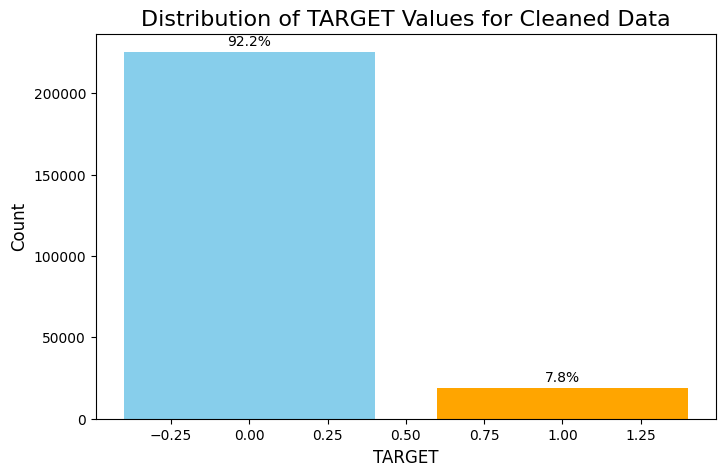

In [9]:
# check target distribution again
plot_value_counts_with_percentages(
    data=df_application_clean,
    column='TARGET',
    colors=['skyblue', 'orange'],
    title='Distribution of TARGET Values for Cleaned Data'
)

### Check & Process Data by Types

In [10]:
dtype_df = pd.DataFrame(df_application_clean.dtypes, columns=['DataType']).reset_index()
dtype_df.columns = ['ColumnName', 'DataType']
dtype_df['DataType'].value_counts()

DataType
int64      41
float64    20
object     11
Name: count, dtype: int64

### A. Flag (Boolean) Variables

In [11]:
flag_columns = [col for col in df_application_clean.columns if set(df_application_clean[col].unique()) <= {0, 1} or set(df_application_clean[col].unique()) <= {'Y', 'N'}]
flag_columns.remove('TARGET')
print(flag_columns)
# Convert identified flag columns to numeric 0 and 1
for col in flag_columns:
    df_application_clean[col] = df_application_clean[col].replace({'Y': 1, 'N': 0}).astype(int)


['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


C:\Users\ruoxi\AppData\Local\Temp\ipykernel_27752\568689019.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_application_clean[col] = df_application_clean[col].replace({'Y': 1, 'N': 0}).astype(int)
C:\Users\ruoxi\AppData\Local\Temp\ipykernel_27752\568689019.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_application_clean[col] = df_application_clean[col].replace({'Y': 1, 'N': 0}).astype(int)


In [12]:
df_application_clean.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,100004,0,Revolving loans,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,0,1,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,1,1,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,1,1,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### B. Categorical Variables

In [13]:
non_numeric_df = df_application_clean.select_dtypes(exclude='number')

pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_rows', None)     
pd.set_option('display.max_columns', None)  
    
unique_values_df = pd.DataFrame({col: [non_numeric_df[col].unique()] for col in non_numeric_df.columns}).transpose()
unique_values_df.columns = ['UniqueValues']
unique_values_df = unique_values_df.reset_index().rename(columns={'index': 'ColumnName'})
unique_values_df

,ColumnName,UniqueValues
0,NAME_CONTRACT_TYPE,"[Cash loans, Revolving loans]"
1,CODE_GENDER,"[M, F, XNA]"
2,NAME_TYPE_SUITE,"[Unaccompanied, Spouse, partner, Children, Family, Other_A, Other_B, Group of people]"
3,NAME_INCOME_TYPE,"[Working, State servant, Commercial associate, Pensioner, Unemployed, Student, Businessman]"
4,NAME_EDUCATION_TYPE,"[Secondary / secondary special, Higher education, Incomplete higher, Lower secondary, Academic degree]"
5,NAME_FAMILY_STATUS,"[Single / not married, Married, Widow, Civil marriage, Separated]"
6,NAME_HOUSING_TYPE,"[House / apartment, Rented apartment, Municipal apartment, With parents, Office apartment, Co-op apartment]"
7,WEEKDAY_APPR_PROCESS_START,"[WEDNESDAY, MONDAY, SUNDAY, SATURDAY, FRIDAY, THURSDAY, TUESDAY]"
8,ORGANIZATION_TYPE,"[Business Entity Type 3, Government, Other, XNA, Medicine, Business Entity Type 2, Self-employed, Housing, Kindergarten, Trade: type 7, Industry: type 11, Military, Transport: type 4, School, Services, Emergency, Security, Trade: type 2, University, Police, Construction, Business Entity Type 1, Industry: type 4, Agriculture, Restaurant, Transport: type 2, Hotel, Industry: type 7, Trade: type 3, Industry: type 3, Bank, Industry: type 9, Postal, Trade: type 6, Industry: type 2, Transport: type 1, Transport: type 3, Electricity, Industry: type 12, Insurance, Industry: type 1, Security Ministries, Mobile, Trade: type 1, Industry: type 5, Industry: type 10, Legal Services, Advertising, Trade: type 5, Cleaning, Industry: type 13, Industry: type 8, Realtor, Culture, Telecom, Religion, Industry: type 6, Trade: type 4]"


In [14]:
# Check domain value with 'XNA'
non_numeric_df['CODE_GENDER'].value_counts()

CODE_GENDER
F      162361
M       81915
XNA         4
Name: count, dtype: int64

In [15]:
#Delete XNA for CODE_GENDER
df_application_clean2 = df_application_clean.drop(df_application_clean[df_application_clean['CODE_GENDER'] == 'XNA'].index)
df_application_clean2.reset_index(drop=True, inplace=True)
df_application_clean2.shape

(244276, 72)

In [16]:
check = df_application_clean2[['SK_ID_CURR','TARGET','ORGANIZATION_TYPE']].groupby(['ORGANIZATION_TYPE','TARGET']).count()
check.loc[['Other','XNA']]

SK_ID_CURR
ORGANIZATION_TYPE TARGET            
Other             0            12379
                  1              995
XNA               0            41639
                  1             2270

In [17]:
#Group XNA with Other
df_application_clean2['ORGANIZATION_TYPE'] = df_application_clean2['ORGANIZATION_TYPE'].replace('XNA', 'Other')

In [18]:
check = df_application_clean2[['SK_ID_CURR','TARGET','ORGANIZATION_TYPE']].groupby(['ORGANIZATION_TYPE','TARGET']).count()
check.loc[['Other']]

SK_ID_CURR
ORGANIZATION_TYPE TARGET            
Other             0            54018
                  1             3265

In [19]:
#check distribution for categorical variables

def plot_categorical_frequencies(df, figsize=(8, 3), colors=None):
    """
    Plots the frequency distribution of all categorical columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with categorical columns.
        figsize (tuple): Size of each plot (default: (10, 6)).
        colors (list): List of colors for the bars (default: None).
    """
    categorical_columns = df.columns

    for column in categorical_columns:
        # Get value counts
        value_counts = df[column].value_counts()

        # Plot the distribution
        plt.figure(figsize=figsize)
        value_counts.plot(kind='bar',rot=45)
        
        # Add title and labels
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

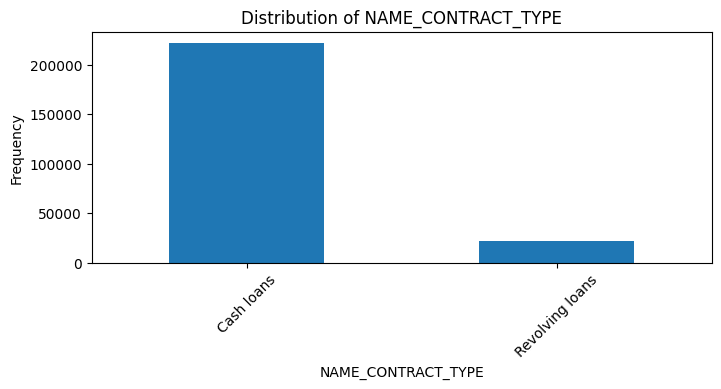

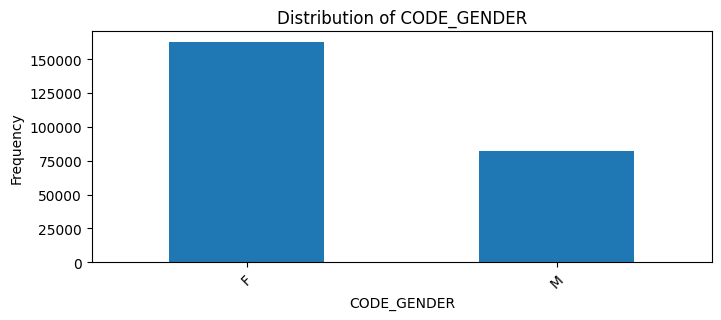

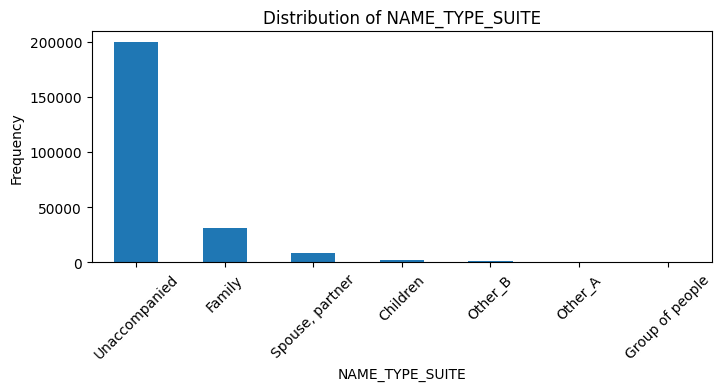

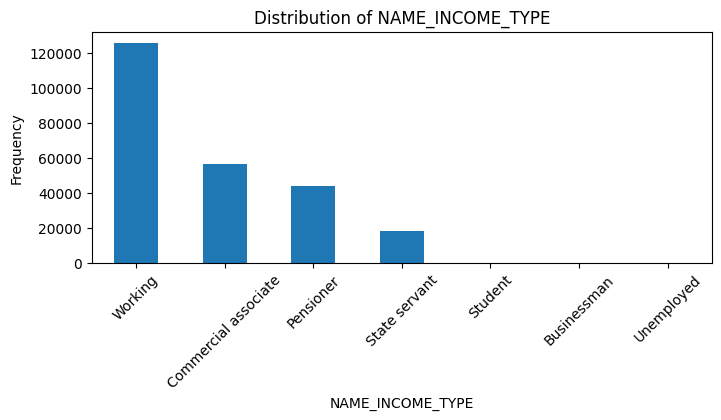

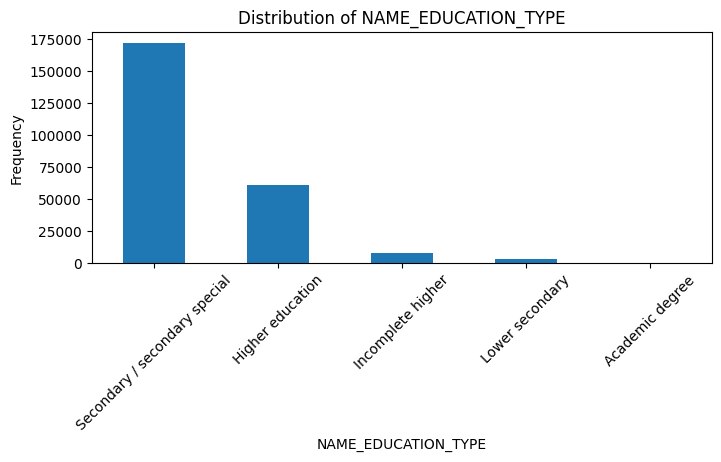

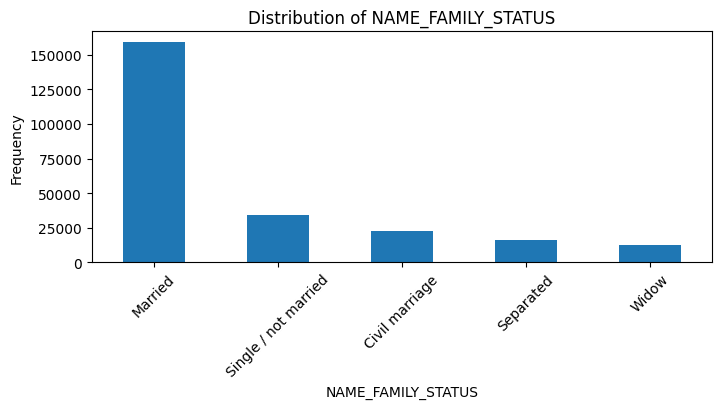

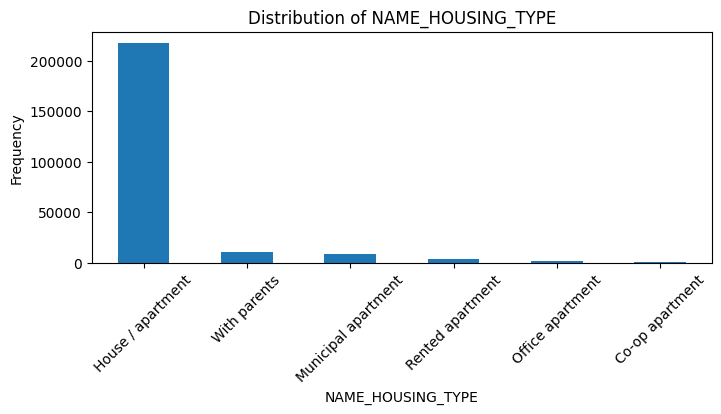

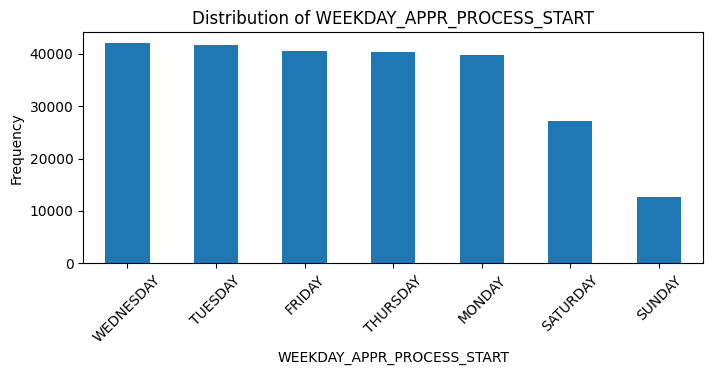

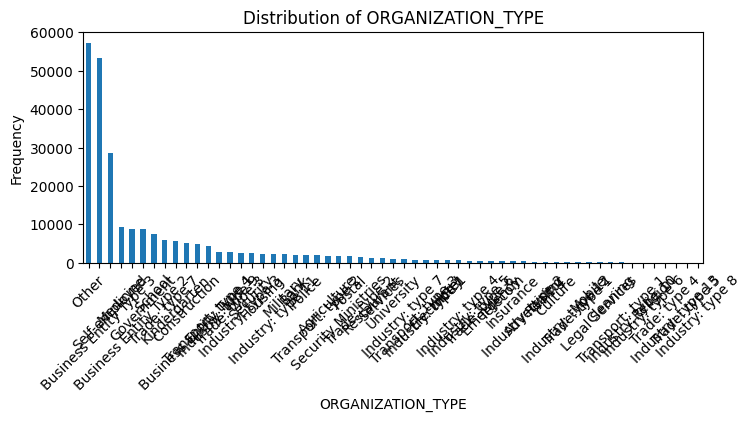

In [20]:
non_numeric_df = df_application_clean2.select_dtypes(exclude='number')
plot_categorical_frequencies(non_numeric_df)

In [21]:
#One hot encoding
non_numeric_columns = df_application_clean2.select_dtypes(exclude='number').columns
encoded_application_clean = pd.get_dummies(df_application_clean2, columns=non_numeric_columns)

In [22]:
encoded_application_clean.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade:

### C.Numerical Variables

In [23]:
numeric_columns= df_application_clean2.select_dtypes(include='number').columns
numeric_columns = numeric_columns.drop(['SK_ID_CURR','TARGET'])
numeric_columns = numeric_columns.drop(flag_columns)
numerical_summary = encoded_application_clean[numeric_columns].describe()
display(numerical_summary)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,244276.000000,2.442760e+05,2.442760e+05,244276.000000,2.442760e+05,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.000000,244276.00000,244276.000000
mean,0.424458,1.718670e+05,6.084740e+05,27205.595192,5.466429e+05,0.020747,-16134.893162,63619.595171,-4988.700961,-3051.456254,2.167348,2.054729,2.034850,12.104411,0.518439,0.510768,1.434852,0.144279,1.418068,0.100210,-996.763849,0.006382,0.006890,0.034477,0.276138,0.26407,1.901464
std,0.726917,2.574339e+05,4.044119e+05,14323.249293,3.710326e+05,0.013676,4297.238042,141215.000092,3519.683696,1489.535558,0.911461,0.502249,0.496762,3.241899,0.189122,0.194842,2.422940,0.447955,2.401941,0.362741,833.395377,0.083840,0.110143,0.204139,0.939155,0.60948,1.859787
min,0.000000,2.610000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25201.000000,-17912.000000,-24672.000000,-7197.000000,1.000000,1.000000,1.000000,0.000000,0.000001,0.000527,0.000000,0.000000,0.000000,0.000000,-4185.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,1.125000e+05,2.750400e+05,16713.000000,2.385000e+05,0.010006,-19724.000000,-2884.000000,-7482.000000,-4321.000000,2.000000,2.000000,2.000000,10.000000,0.400904,0.370650,0.000000,0.000000,0.000000,0.000000,-1611.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,1.575000e+05,5.212800e+05,25060.500000,4.500000e+05,0.018850,-15832.000000,-1281.000000,-4518.000000,-3336.000000,2.000000,2.000000,2.000000,12.000000,0.569991,0.535276,0.000000,0.000000,0.000000,0.000000,-812.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,1.000000,2.025000e+05,8.140410e+05,34780.500000,6.885000e+05,0.028663,-12602.000000,-307.000000,-2004.000000,-1818.000000,3.000000,2.000000,2.000000,14.000000,0.665158,0.669057,2.000000,0.000000,2.000000,0.000000,-293.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.000000
max,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7676.000000,365243.000000,0.000000,0.000000,20.000000,3.000000,3.000000,23.000000,0.855000,0.896010,348.000000,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,8.00000,23.000000


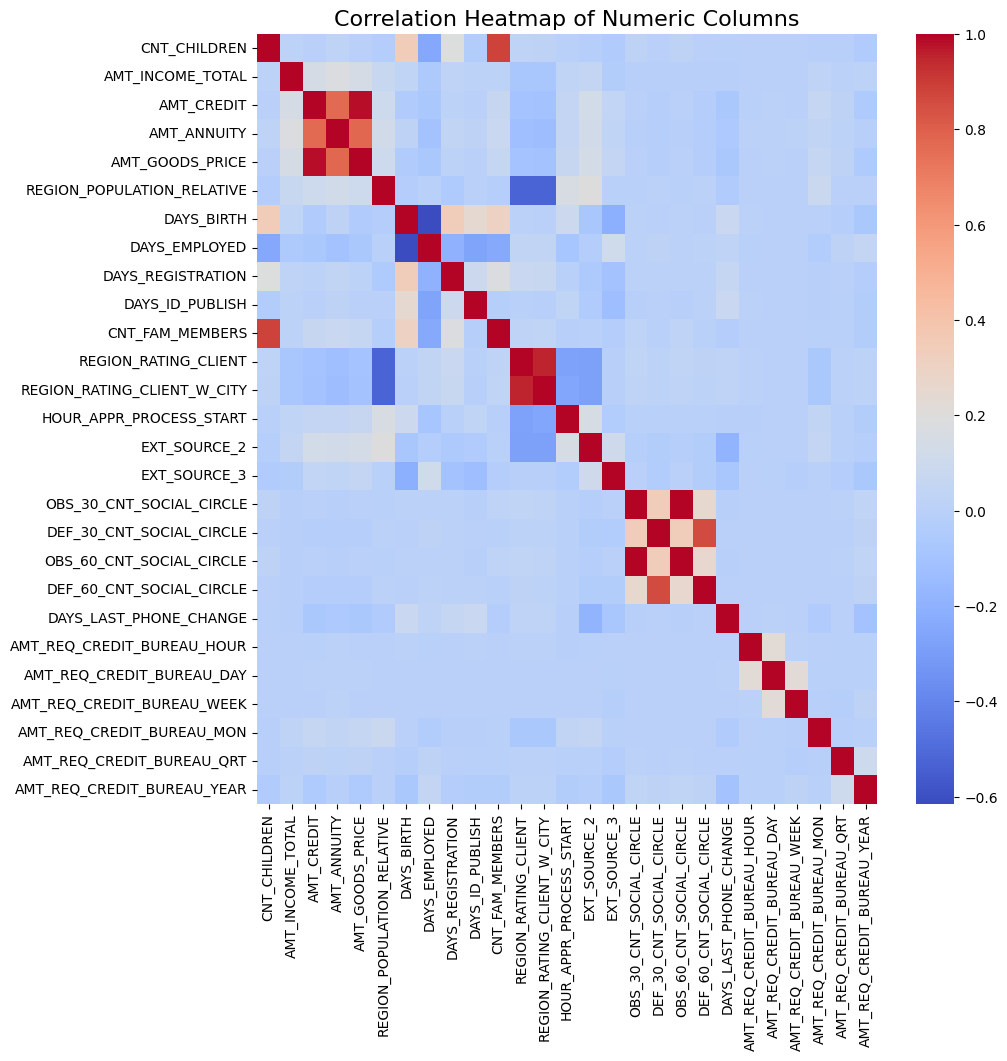

In [24]:
#check correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for numeric columns
correlation_matrix = df_application_clean2[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 10)) 
sns.heatmap(correlation_matrix, fmt=".2f", cmap="coolwarm", cbar=True)

# Add title
plt.title('Correlation Heatmap of Numeric Columns', fontsize=16)
plt.show()

In [25]:
#Top 10 correlation
# Compute the correlation matrix for numeric columns
correlation_matrix = df_application_clean2[numeric_columns].corr()

# Flatten the correlation matrix and exclude self-correlations
correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs[correlation_pairs.index.get_level_values(0) != correlation_pairs.index.get_level_values(1)]

# Sort by absolute value and get the top 10 correlations
top_10_correlations = correlation_pairs.abs().sort_values(ascending=False).head(10)

# Print the top 10 correlations with their feature pairs
print("Top 10 Correlations:")
for (feature1, feature2), correlation in top_10_correlations.items():
    print(f"{feature1} and {feature2}: {correlation:.2f}")

Top 10 Correlations:
OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE: 1.00
OBS_60_CNT_SOCIAL_CIRCLE and OBS_30_CNT_SOCIAL_CIRCLE: 1.00
AMT_GOODS_PRICE and AMT_CREDIT: 0.99
AMT_CREDIT and AMT_GOODS_PRICE: 0.99
REGION_RATING_CLIENT_W_CITY and REGION_RATING_CLIENT: 0.95
REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY: 0.95
CNT_FAM_MEMBERS and CNT_CHILDREN: 0.88
CNT_CHILDREN and CNT_FAM_MEMBERS: 0.88
DEF_60_CNT_SOCIAL_CIRCLE and DEF_30_CNT_SOCIAL_CIRCLE: 0.86
DEF_30_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE: 0.86


In [26]:
# standardize 
from sklearn.preprocessing import StandardScaler
encoded_application_clean_std = encoded_application_clean.copy()
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_application_clean[numeric_columns])


## **2.0** Feature & Model Selection

### PCA

In [54]:
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Calculate Statistics Before and After Standardization
def calculate_statistics(data, label):
    variance = data.var().sum()
    skewness = data.apply(lambda x: skew(x))
    kurtosis_values = data.apply(lambda x: kurtosis(x))
    print(f"\n### {label} ###")
    print(f"Total Variance: {variance:.4f}")
    print(f"Skewness:\n{skewness}")
    print(f"Kurtosis:\n{kurtosis_values}")
    return variance, skewness, kurtosis_values

# Calculate statistics before standardization
variance_before, skewness_before, kurtosis_before = calculate_statistics(
    pd.DataFrame(X_scaled, columns=numeric_columns), "After Standardization"
)

# Step 2: Yeo-Johnson Transformation for Handling Skewness and Kurtosis
transformer = PowerTransformer(method='yeo-johnson', standardize=False)
X_transformed = transformer.fit_transform(X_scaled)
X_transformed_df = pd.DataFrame(X_transformed, columns=numeric_columns)

# Calculate statistics after Yeo-Johnson transformation
variance_after_transform, skewness_after_transform, kurtosis_after_transform = calculate_statistics(
    X_transformed_df, "After Yeo-Johnson Transformation"
)

# Step 3: PCA Analysis
pca = PCA()
pca_transformed = pca.fit_transform(X_transformed)

# Plot cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid()
plt.show()

# Determine the optimal number of components (95% variance)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of PCA components to retain 95% variance: {optimal_components}")

# Step 4: Apply PCA with Optimal Number of Components
pca_optimal = PCA(n_components=optimal_components)
X_pca_optimal = pca_optimal.fit_transform(X_transformed)




### After Standardization ###
Total Variance: 27.0001
Skewness:
CNT_CHILDREN                     1.924701
AMT_INCOME_TOTAL               383.168157
AMT_CREDIT                       1.199433
AMT_ANNUITY                      1.518657
AMT_GOODS_PRICE                  1.308801
REGION_POPULATION_RELATIVE       1.487751
DAYS_BIRTH                      -0.111220
DAYS_EMPLOYED                    1.667117
DAYS_REGISTRATION               -0.584094
DAYS_ID_PUBLISH                  0.390190
CNT_FAM_MEMBERS                  0.973577
REGION_RATING_CLIENT             0.103782
REGION_RATING_CLIENT_W_CITY      0.073481
HOUR_APPR_PROCESS_START         -0.018132
EXT_SOURCE_2                    -0.822602
EXT_SOURCE_3                    -0.409233
OBS_30_CNT_SOCIAL_CIRCLE        14.228884
DEF_30_CNT_SOCIAL_CIRCLE         5.479254
OBS_60_CNT_SOCIAL_CIRCLE        14.138075
DEF_60_CNT_SOCIAL_CIRCLE         5.479829
DAYS_LAST_PHONE_CHANGE          -0.642264
AMT_REQ_CREDIT_BUREAU_HOUR      14.643642
AMT_REQ_CRE

KeyboardInterrupt: 

In [ ]:
#Final Dataset- ready for feature selection
encoded_application_clean_std.head(5)

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade:

### Feature Selection

### Rondom Forest Feature

In [ ]:
df = encoded_application_clean  # make a duplicate just in case

# Separate features and target variable
X = df.drop(columns=['TARGET'])  # Features 
y = df['TARGET']                 # Target


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import randint

rf = RandomForestClassifier(random_state=42)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

                   Feature  Importance
30            EXT_SOURCE_3    0.070888
29            EXT_SOURCE_2    0.064699
9               DAYS_BIRTH    0.046214
12         DAYS_ID_PUBLISH    0.045235
11       DAYS_REGISTRATION    0.045174
0               SK_ID_CURR    0.043951
6              AMT_ANNUITY    0.042334
35  DAYS_LAST_PHONE_CHANGE    0.041061
10           DAYS_EMPLOYED    0.040061
5               AMT_CREDIT    0.038841


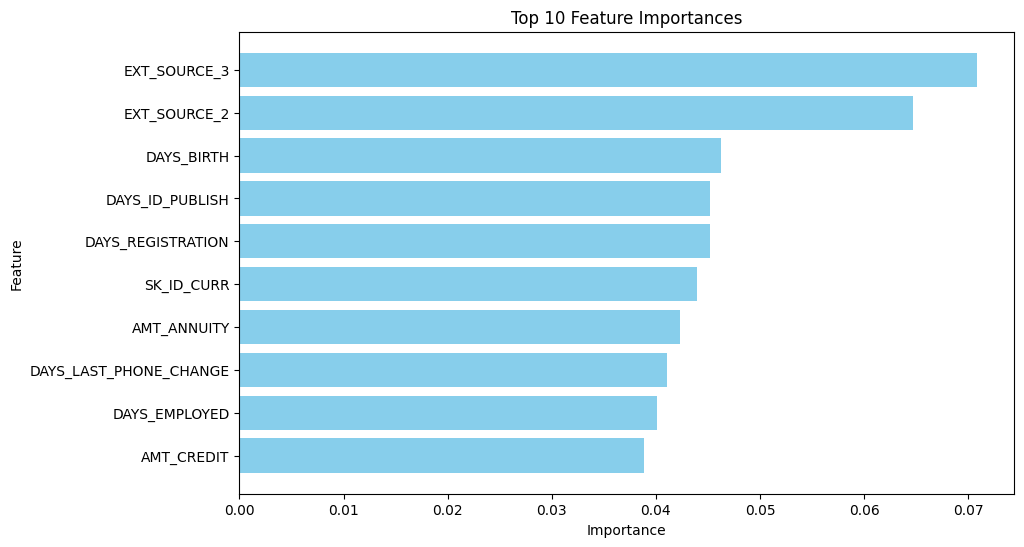

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

feature_importances = rf.feature_importances_

# Create a DataFrame with feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order and get the top 10 features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Print the top 10 features
print(top_features)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [ ]:
df = encoded_application_clean  # make a duplicate just in case

# Separate features and target variable
X = df.drop(columns=['TARGET'])  # Features
y = df['TARGET']                 # Target

# Standardize the features for Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit Lasso Regression for feature selection
lasso = Lasso(alpha=0.001)  # higher alpha = stronger penalty
lasso.fit(X_train, y_train)

# Extract features with non-zero coefficients
selected_features = X.columns[lasso.coef_ != 0].tolist()

print("Selected Features by Lasso Regression:")
print(selected_features)
print("Number of selected features:", len(selected_features))

Selected Features by Lasso Regression:
['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_F', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATI

In [ ]:
# Create a duplicate of the encoded DataFrame (optional, for safety)
df = encoded_application_clean.copy()

# Separate features and target variable
# Use PCA-transformed features instead of original features
X = X_pca_optimal  # PCA-transformed features from the previous cell
y = df['TARGET']   # Target variable

# Split the PCA-transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Lasso Regression for feature selection on PCA-transformed data
lasso = Lasso(alpha=0.001)  # Regularization strength (higher alpha = stronger penalty)
lasso.fit(X_train, y_train)

# Extract indices of PCA components with non-zero coefficients
selected_pca_components = [i for i, coef in enumerate(lasso.coef_) if coef != 0]

print("Selected PCA Components by Lasso Regression:")
print(selected_pca_components)
print("Number of selected PCA components:", len(selected_pca_components))


Selected PCA Components by Lasso Regression:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Number of selected PCA components: 15


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Filter the training and testing sets to only include selected features
X_train_selected = X_train[:, lasso.coef_ != 0]
X_test_selected = X_test[:, lasso.coef_ != 0]

# Step 2: Train and evaluate Random Forest model using all features
rf_all_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all_features.fit(X_train, y_train)

y_pred_all = rf_all_features.predict(X_test)
y_pred_proba_all = rf_all_features.predict_proba(X_test)[:, 1]

# Evaluate model with all features
accuracy_all = accuracy_score(y_test, y_pred_all)
f1_all = f1_score(y_test, y_pred_all)
roc_auc_all = roc_auc_score(y_test, y_pred_proba_all)

print("Random Forest Performance with All Features:")
print(f"Accuracy: {accuracy_all:.4f}")
print(f"F1 Score: {f1_all:.4f}")
print(f"ROC AUC Score: {roc_auc_all:.4f}")

# Step 3: Train and evaluate Random Forest model using only Lasso-selected features
rf_selected_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected_features.fit(X_train_selected, y_train)

y_pred_selected = rf_selected_features.predict(X_test_selected)
y_pred_proba_selected = rf_selected_features.predict_proba(X_test_selected)[:, 1]

# Evaluate model with Lasso-selected features
accuracy_selected = accuracy_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)
roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected)

print("\nRandom Forest Performance with Lasso-Selected Features:")
print(f"Accuracy: {accuracy_selected:.4f}")
print(f"F1 Score: {f1_selected:.4f}")
print(f"ROC AUC Score: {roc_auc_selected:.4f}")

Random Forest Performance with All Features:
Accuracy: 0.9219
F1 Score: 0.0005
ROC AUC Score: 0.6868

Random Forest Performance with Lasso-Selected Features:
Accuracy: 0.9219
F1 Score: 0.0005
ROC AUC Score: 0.6868


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Use PCA-transformed features instead of the original features
X = X_pca_optimal  # PCA-transformed features from the previous PCA implementation
y = df['TARGET']   # Target variable

# Split the PCA-transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Train and evaluate Random Forest model using all PCA-transformed features
rf_all_features = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_all_features.fit(X_train, y_train)

# Make predictions and calculate probabilities
y_pred_all = rf_all_features.predict(X_test)
y_pred_proba_all = rf_all_features.predict_proba(X_test)[:, 1]

# Evaluate model with all PCA components
accuracy_all = accuracy_score(y_test, y_pred_all)
f1_all = f1_score(y_test, y_pred_all)
roc_auc_all = roc_auc_score(y_test, y_pred_proba_all)

print("Random Forest Performance with All PCA Components:")
print(f"Accuracy: {accuracy_all:.4f}")
print(f"F1 Score: {f1_all:.4f}")
print(f"ROC AUC Score: {roc_auc_all:.4f}")

# Step 2: Train and evaluate Random Forest model using Lasso-selected PCA components
# Filter the training and testing sets to include only Lasso-selected components
X_train_selected = X_train[:, selected_pca_components]
X_test_selected = X_test[:, selected_pca_components]

rf_selected_features = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_selected_features.fit(X_train_selected, y_train)

# Make predictions and calculate probabilities
y_pred_selected = rf_selected_features.predict(X_test_selected)
y_pred_proba_selected = rf_selected_features.predict_proba(X_test_selected)[:, 1]

# Evaluate model with Lasso-selected PCA components
accuracy_selected = accuracy_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)
roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected)

print("\nRandom Forest Performance with Lasso-Selected PCA Components:")
print(f"Accuracy: {accuracy_selected:.4f}")
print(f"F1 Score: {f1_selected:.4f}")
print(f"ROC AUC Score: {roc_auc_selected:.4f}")


Random Forest Performance with All PCA Components:
Accuracy: 0.9220
F1 Score: 0.0026
ROC AUC Score: 0.6925

Random Forest Performance with Lasso-Selected PCA Components:
Accuracy: 0.9220
F1 Score: 0.0026
ROC AUC Score: 0.6925


### Christina's Logistic Regression with L1 Regularization

#### 1st Attempt: Default

This section trains a logistic regression model with L1 regularization to predict the target variable. Key steps include:

- **Preprocessing**: Standardizing features and splitting the data into training and testing sets (80/20 split).
- **Modeling**: Training a logistic regression model using L1 regularization to enhance feature selection.
- **Evaluation**: Assessing the model's performance using accuracy, F1 score, and ROC AUC. A confusion matrix is also visualized for detailed insights.
- **Feature Selection**: Identifying important features with non-zero coefficients, simplifying the model.

#### Findings:
- **Accuracy**: The model achieved a high accuracy of **92.17%**, indicating it correctly classifies most observations.
- **F1 Score**: The F1 score is **0.0175**, highlighting poor performance in balancing precision and recall, likely due to class imbalance.
- **ROC AUC**: The score of **0.7445** suggests the model has moderate ability to distinguish between classes.
- **Confusion Matrix**: The model performs well on the majority class but struggles with the minority class (only 34 true positives out of 3816 positives).

#### Notes:
- The model failed to converge within the maximum iterations. Consider increasing `max_iter` or improving feature scaling for better optimization.
- The low F1 score indicates the need to address class imbalance, perhaps by oversampling the minority class or using a weighted loss function.


Logistic Regression with L1 Regularization Performance:
Accuracy: 0.9217
F1 Score: 0.0175
ROC AUC Score: 0.7445

Confusion Matrix:
[[44996    44]
 [ 3782    34]]


C:\Users\ruoxi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


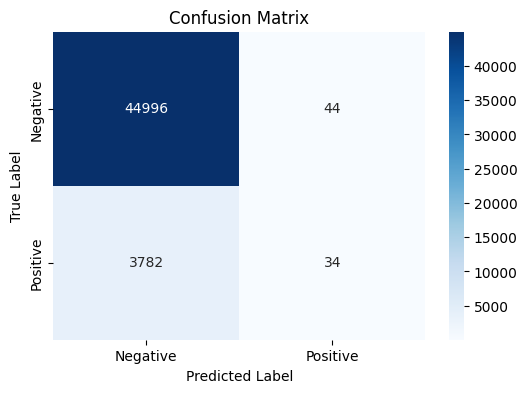


Selected Features by L1 Regularization:
Index(['SK_ID_CURR', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 4',
       'ORGANIZATION_TYPE_Trade: type 5', 'ORGANIZATION_TYPE_Trade: type 6',
       'ORGANIZATION_TYPE_Trade: type 7',
       'ORGANIZATION_TYPE_Transport: type 1',
       'ORGANIZATION_TYPE_Transport: type 2',
       'ORGANIZATION_TYPE_Transport: type 3',
       'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University'],
      dtype='object', length=155)
Number of Selected Features: 155


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

df = encoded_application_clean.copy()

X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression with L1 Regularization
log_reg_l1 = LogisticRegression(
    penalty='l1',           # L1 regularization
    solver='saga',          # Saga solver supports L1 regularization
    max_iter=2000,          # Ensure sufficient iterations for convergence
    tol=1e-4,               # Convergence tolerance
    C=1.0,                  # Regularization strength (smaller values increase regularization)
    random_state=42
)

# Fit the model
log_reg_l1.fit(X_train, y_train)

# Evaluate the model
y_pred = log_reg_l1.predict(X_test)
y_pred_proba = log_reg_l1.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)


print("Logistic Regression with L1 Regularization Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


selected_features = X.columns[log_reg_l1.coef_.flatten() != 0]
print("\nSelected Features by L1 Regularization:")
print(selected_features)
print(f"Number of Selected Features: {len(selected_features)}")


#### Although the accuracy is very high, but it is misleading as we can see from the confusion matrix that the true positive is extremely low

#### Therefore, I'll try another threshold


Adjusted Threshold Performance:
Accuracy: 0.9149
F1 Score: 0.1573
ROC AUC Score: 0.7445
Confusion Matrix (Adjusted Threshold):
[[44311   729]
 [ 3428   388]]


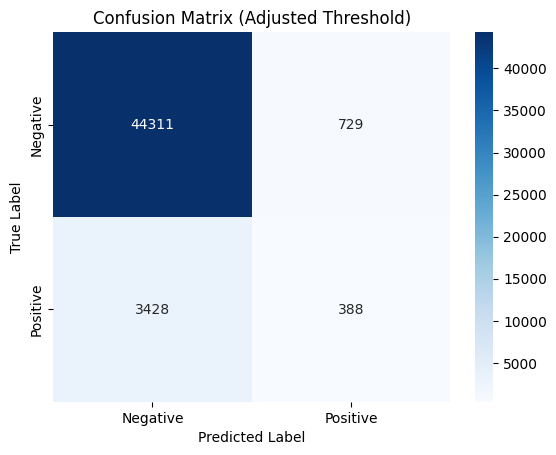

In [ ]:
# Adjust threshold
threshold = 0.3  # Experiment with different thresholds
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Recompute metrics
accuracy_adj = accuracy_score(y_test, y_pred_adjusted)
f1_adj = f1_score(y_test, y_pred_adjusted)
roc_auc_adj = roc_auc_score(y_test, y_pred_proba)
conf_matrix_adj = confusion_matrix(y_test, y_pred_adjusted)

print("\nAdjusted Threshold Performance:")
print(f"Accuracy: {accuracy_adj:.4f}")
print(f"F1 Score: {f1_adj:.4f}")
print(f"ROC AUC Score: {roc_auc_adj:.4f}")
print("Confusion Matrix (Adjusted Threshold):")
print(conf_matrix_adj)

# Plot confusion matrix
sns.heatmap(conf_matrix_adj, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.show()


#### With a new threshold of 0,3, the result is incrementally better, but no where close to ideal
#### We need to try oversampling the true target data

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Re-train the logistic regression model
log_reg_l1.fit(X_resampled, y_resampled)
y_pred_resampled = log_reg_l1.predict(X_test)
y_pred_proba_resampled = log_reg_l1.predict_proba(X_test)[:, 1]

# Evaluate
conf_matrix_resampled = confusion_matrix(y_test, y_pred_resampled)
print("\nConfusion Matrix (After Resampling):")
print(conf_matrix_resampled)


Confusion Matrix (After Resampling):
[[31640 13400]
 [ 1352  2464]]


C:\Users\ruoxi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### The result is more desirable, and now we can combine both resampling and a new threshold


Performance (Default Threshold):
Accuracy: 0.6922
F1 Score: 0.2531
ROC AUC Score: 0.7428
Confusion Matrix:
[[31270 13770]
 [ 1268  2548]]


C:\Users\ruoxi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


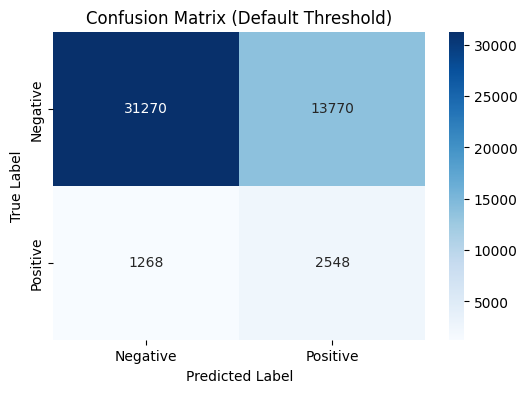


Performance (Adjusted Threshold):
Accuracy: 0.3928
F1 Score: 0.1892
ROC AUC Score: 0.7428
Confusion Matrix:
[[15733 29307]
 [  356  3460]]


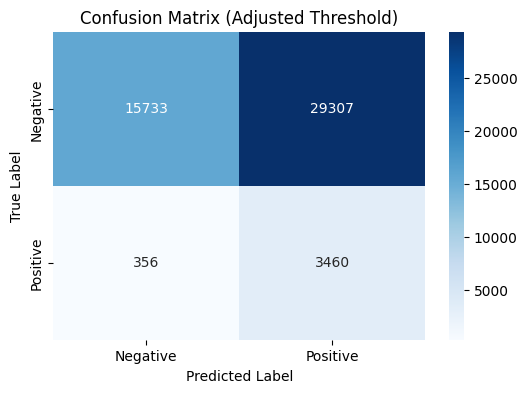

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

df = encoded_application_clean.copy()
X = df.drop(columns=['TARGET'])
y = df['TARGET']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

log_reg_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=2000, tol=1e-4, C=1.0, random_state=42)
log_reg_l1.fit(X_resampled, y_resampled)

y_pred_proba = log_reg_l1.predict_proba(X_test)[:, 1]
y_pred_default = (y_pred_proba >= 0.5).astype(int)

threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

def evaluate_model(y_true, y_pred, y_proba, threshold_label):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    print(f"\nPerformance ({threshold_label} Threshold):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({threshold_label} Threshold)')
    plt.show()

evaluate_model(y_test, y_pred_default, y_pred_proba, "Default")
evaluate_model(y_test, y_pred_adjusted, y_pred_proba, "Adjusted")


#### Looks like the threshold of 0.3 doesn't hold anymore, we need to find the right threshold

Best Threshold based on F1 Score: 0.14438634037428869
Best Threshold based on Youden's Index (ROC Curve): 0.07965841298652734


ValueError: x and y must have same first dimension, but have shapes (48856,) and (48857,)

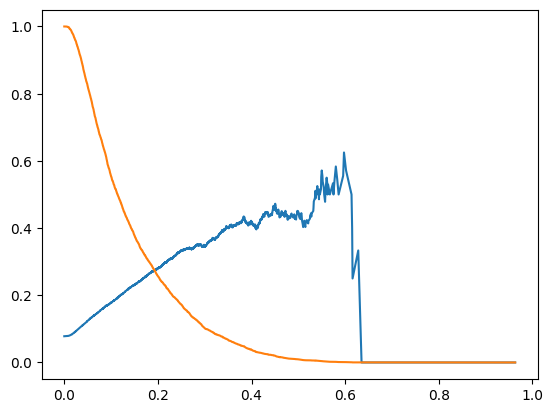

In [ ]:
# Ensure all arrays match in length
precision = precision[:-1]  # Match the length of thresholds
recall = recall[:-1]
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Recalculate F1 scores

# Plot using thresholds
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision, Recall, F1 Score vs Threshold")
plt.show()

plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
best_threshold = best_threshold_f1 

# Adjust predictions based on best threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# Evaluate the model with adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [ ]:
from sklearn.metrics import classification_report

# Display overall performance metrics
print(f"\nPerformance with Adjusted Threshold ({best_threshold:.4f}):")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Negative', 'Positive']))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.show()

### Yunjing's Candidate Method - **XGBOOST**

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#### 0.create data for training and testing

In [ ]:
df = encoded_application_clean.copy()  # make a duplicate just in case

# Separate features and target variable
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])  # Features
y = df['TARGET']                               # Target

# Identify flag variables (binary 0/1) and non-flag (continuous) variables
flag_columns = X.columns[(X.nunique() == 2) & X.isin([0, 1]).all()]  # Binary 0/1 columns
non_flag_columns = X.columns.difference(flag_columns)               # All other columns

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a ColumnTransformer to scale only non-flag columns
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), non_flag_columns)  # Apply scaler to non-flag columns
    ],
    remainder='passthrough'  # Keep flag columns unchanged
)

# Fit the transformer on training data and transform both training and test data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

#### function for confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_confusion_matrix(y_true, y_pred, display_labels=None):

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Extract TN, FP, FN, TP from the confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()
    
    # Calculate rates
    TP_rate = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity or Recall
    FP_rate = FP / (FP + TN) if (FP + TN) > 0 else 0  # Fall-out
    FN_rate = FN / (TP + FN) if (TP + FN) > 0 else 0  # Miss rate
    TN_rate = TN / (FP + TN) if (FP + TN) > 0 else 0  # Specificity

    # Print the rates
    print(f"True Positive Rate (Recall): {TP_rate:.2f}")
    print(f"False Positive Rate: {FP_rate:.2f}")
    print(f"False Negative Rate: {FN_rate:.2f}")
    print(f"True Negative Rate (Specificity): {TN_rate:.2f}")
    
    # Visualize the confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()


#### 1.Initial XGB Classifier
##### Create an initial simple XGB model to get a view of the preliminary result

In [ ]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',       # Evaluation metric
    use_label_encoder=False,     # Avoid label encoding warnings
    random_state=42
)

# Train the model
xgb_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_prob = xgb_classifier.predict_proba(X_test_scaled)[:, 1]  # Probabilities for positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Accuracy: {accuracy:.6f}")
print(f"ROC AUC: {roc_auc:.6f}")

/Users/yunjingzhan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:43:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.921340
ROC AUC: 0.743942


True Positive Rate (Recall): 0.03
False Positive Rate: 0.00
False Negative Rate: 0.97
True Negative Rate (Specificity): 1.00


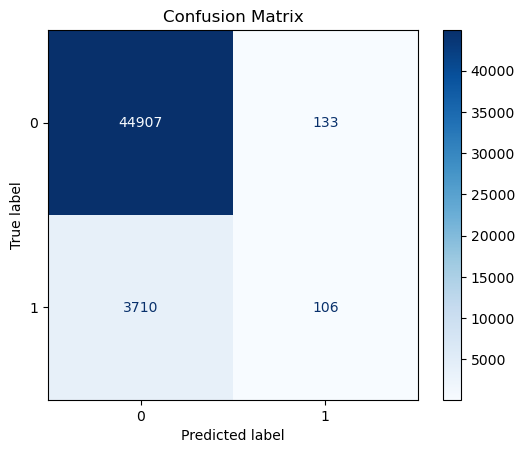

In [ ]:
evaluate_confusion_matrix(y_test, y_pred, display_labels=xgb_classifier.classes_)

##### Based on the testing metrics above, although the accuracy appears very high, this is primarily due to the imbalanced nature of the dataset. Our goal is to achieve more accurate predictions for customers who may default. Therefore, we need to prioritize metrics such as the True Positive Rate and AUC over accuracy. In this initial model, the True Positive Rate is significantly low (only 3%), indicating the need to address the data imbalance and further tune the model for improved performance.

#### 2. Address the **imbalanced data** issue by adding weight
#####  As we can see in EDA, this data only has ~10% target = 1 which indicates the data is imbalanced. The scale_pos_weight parameter adjusts the weight of positive class instances, making the model focus more on the minority class.

In [ ]:
neg_class = y_train.value_counts()[0]
pos_class = y_train.value_counts()[1]
scale_pos_weight = neg_class / pos_class
scale_pos_weight

11.843059936908517

#### 3.reduce feature

##### As we can see from the EDA, there are many variable in this data has high correlation and also having too many features increases the risk of overfitting, especially if some features are irrelevant or noisy. Moreover, Reducing features decreases the number of splits the algorithm has to evaluate, speeding up training. Therefore, We applied a simple XGB Classfier and select top 50 features based on importance.

In [ ]:
# Fit a preliminary model
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train_scaled, y_train)

# Select top 50 features based on importance
feature_importances = xgb_model.feature_importances_

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

important_features = X_train_scaled.columns[feature_importances.argsort()[-50:]]
X_train_reduced = X_train_scaled[important_features]
X_test_reduced = X_test_scaled[important_features]


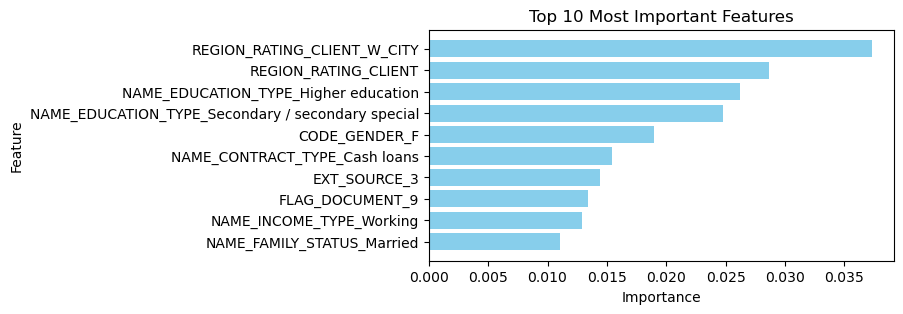

In [ ]:
import matplotlib.pyplot as plt
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(6, 3))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##### The top 10 features align well with the context of credit risk classification. For example, the rating of the region where the borrower resides, the borrower’s education level, and their employment status are all highly relevant factors that could influence a client’s ability to repay the loan and the risk of default.

#### 4. XGBOOST with weight adjustment & reduced features

In [ ]:
xgb_classifier2 = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight, # adjust weight
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',       # Evaluation metric
    use_label_encoder=False,     # Avoid label encoding warnings
    random_state=42
)

# Train the model
xgb_classifier2.fit(X_train_reduced, y_train)

# Make predictions
y_pred = xgb_classifier2.predict(X_test_reduced)
y_pred_prob = xgb_classifier2.predict_proba(X_test_reduced)[:, 1]  # Probabilities for positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Accuracy: {accuracy:.6f}")
print(f"ROC AUC: {roc_auc:.6f}")

/Users/yunjingzhan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:44:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.735120
ROC AUC: 0.734212


True Positive Rate (Recall): 0.60
False Positive Rate: 0.25
False Negative Rate: 0.40
True Negative Rate (Specificity): 0.75


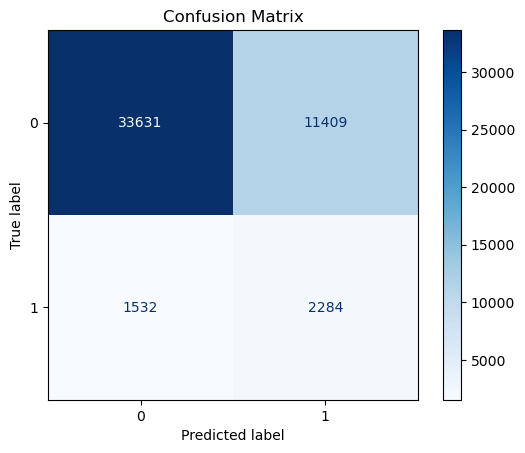

In [ ]:
evaluate_confusion_matrix(y_test, y_pred, display_labels=xgb_classifier2.classes_)

##### As we can see from the confusion martix from the second XGBOOST Model. The ture positive rate sigifincantly improved from 3% to 60%. This is due to the scale_pos_weight parameter adjustment. The reduced feature also helpped in eliminating the impact of irrelavant and noisy features. However, the AUC slightly decreased which means we need to perform further hyperparameter tuning.

#### 5.Hyperparameter Tuning

In [ ]:
# Randomly sample 10% of the data while preserving class distribution
subset_X_train, _, subset_y_train, _ = train_test_split(
    X_train_reduced, y_train, test_size=0.9, stratify=y_train, random_state=42
)

print(subset_X_train.shape)
print(subset_y_train.shape)

(19542, 50)
(19542,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [scale_pos_weight * 0.5, scale_pos_weight, scale_pos_weight * 1.5]  # Range of weights
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(),
    param_distributions=param_grid,
    n_iter=50,  # Test 50 combinations
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(subset_X_train, subset_y_train)

# Best parameters from random search
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 5.921529968454259, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}


#### 6. Recommended candidate model -XGBOOST 

In [ ]:

# Use the best parameters to train a new model
xgb_best_model = xgb.XGBClassifier(
    subsample=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    gamma =0,
    colsample_bytree=0.8,
    scale_pos_weight=5.921529968454259,
    objective='binary:logistic',  # Ensure the same objective
    use_label_encoder=False,
    random_state=42
)

# Train the model on the full training set
xgb_best_model.fit(X_train_reduced, y_train)

# Make predictions
y_pred = xgb_best_model.predict(X_test_reduced)
y_pred_prob = xgb_best_model.predict_proba(X_test_reduced)[:, 1]

# Evaluate the model
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.6f}")
print(f"ROC AUC: {roc_auc:.6f}")

/Users/yunjingzhan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.861982
ROC AUC: 0.740984


True Positive Rate (Recall): 0.35
False Positive Rate: 0.09
False Negative Rate: 0.65
True Negative Rate (Specificity): 0.91


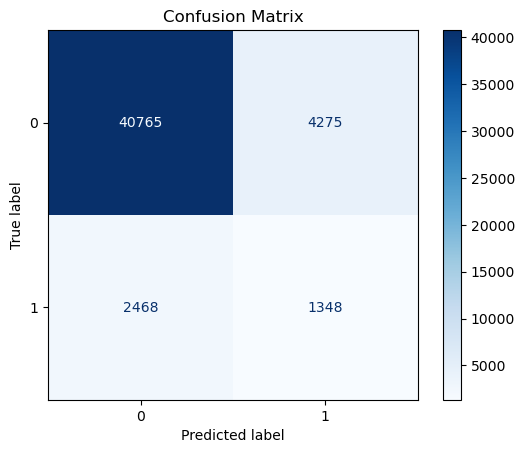

In [ ]:
evaluate_confusion_matrix(y_test, y_pred, display_labels=xgb_best_model.classes_)

#### This model demonstrates relatively better performance in terms of accuracy, AUC, and True Positive Rate & True Negative Rate. Compared to the previous model, the True Positive Rate has decreased, but the True Negative Rate has increased, along with improvements in both accuracy and AUC. Although the previous model showed a significantly higher True Positive Rate, it compromised heavily on the False Positive Rate, which adversely impacted the overall accuracy. Balancing these metrics requires a trade-off, and this model is recommended due to its more balanced performance.

In [ ]:
##start random forest without feauture engineering

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Step 1: Drop unnecessary columns and prepare features and target
df = encoded_application_clean.copy()
X = df.drop(columns=['TARGET'])
y = df['TARGET']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Scale numerical columns only (leave binary columns unchanged)
scaler = StandardScaler()
binary_columns = X_train.columns[(X_train.nunique() == 2) & X_train.isin([0, 1]).all()]
numerical_columns = X_train.columns.difference(binary_columns)

# Apply scaling only to numerical columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Step 4: Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

# Step 5: Train a baseline Random Forest model
baseline_rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
baseline_rf.fit(X_train_resampled, y_train_resampled)

# Step 6: Evaluate the baseline model
y_pred_baseline = baseline_rf.predict(X_test)
y_pred_prob_baseline = baseline_rf.predict_proba(X_test)[:, 1]

# Print baseline evaluation metrics
print("Baseline Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_baseline):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

# Display confusion matrix
conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix (Baseline):")
print(conf_matrix_baseline)

Baseline Random Forest Performance:
Accuracy: 0.9150
ROC AUC Score: 0.7148

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     45050
           1       0.27      0.05      0.09      3806

    accuracy                           0.91     48856
   macro avg       0.60      0.52      0.52     48856
weighted avg       0.87      0.91      0.89     48856


Confusion Matrix (Baseline):
[[44493   557]
 [ 3598   208]]


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a subset of training data for faster tuning
subset_X_train, _, subset_y_train, _ = train_test_split(
    X_train_resampled, y_train_resampled,
    test_size=0.8,  # Use only 20% of training data
    stratify=y_train_resampled,  # Preserve class distribution
    random_state=42
)

# set parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'max_samples': [0.7, 0.8, None],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}],
}

# Perform randomized search with cross-validation
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search_rf.fit(subset_X_train, subset_y_train)

# Display the best parameters
print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best Parameters from RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': None, 'class_weight': {0: 1, 1: 2}, 'bootstrap': True}


In [ ]:
# Train the optimized Random Forest with the best parameters
best_params = random_search_rf.best_params_
optimized_rf = RandomForestClassifier(**best_params, random_state=42)
optimized_rf.fit(X_train_resampled, y_train_resampled)

# Evaluate the optimized model
y_pred_optimized = optimized_rf.predict(X_test)
y_pred_prob_optimized = optimized_rf.predict_proba(X_test)[:, 1]

# Print evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized))

# Display confusion matrix
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
print("\nConfusion Matrix (Optimized):")
print(conf_matrix_optimized)



Optimized Random Forest Performance:
Accuracy: 0.9105
ROC AUC Score: 0.7171

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     45050
           1       0.26      0.08      0.12      3806

    accuracy                           0.91     48856
   macro avg       0.59      0.53      0.54     48856
weighted avg       0.87      0.91      0.89     48856


Confusion Matrix (Optimized):
[[44181   869]
 [ 3503   303]]


In [ ]:
# Adjust threshold
threshold = 0.3  # Experiment with different values
y_pred_adjusted = (y_pred_prob_optimized >= threshold).astype(int)

# Evaluate the adjusted model
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Display confusion matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
print("\nConfusion Matrix (Adjusted Threshold):")
print(conf_matrix_adjusted)


Performance with Adjusted Threshold:
Accuracy: 0.8050
ROC AUC Score: 0.7171

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     45050
           1       0.18      0.42      0.25      3806

    accuracy                           0.80     48856
   macro avg       0.56      0.63      0.57     48856
weighted avg       0.89      0.80      0.84     48856


Confusion Matrix (Adjusted Threshold):
[[37716  7334]
 [ 2194  1612]]



Top 10 Most Important Features:
                                              Feature  Importance
30                                       EXT_SOURCE_3    0.067456
29                                       EXT_SOURCE_2    0.048669
61                         AMT_REQ_CREDIT_BUREAU_YEAR    0.041690
35                             DAYS_LAST_PHONE_CHANGE    0.030654
7                                     AMT_GOODS_PRICE    0.029577
9                                          DAYS_BIRTH    0.029120
8                          REGION_POPULATION_RELATIVE    0.028466
84  NAME_EDUCATION_TYPE_Secondary / secondary special    0.028441
4                                    AMT_INCOME_TOTAL    0.027509
5                                          AMT_CREDIT    0.026806


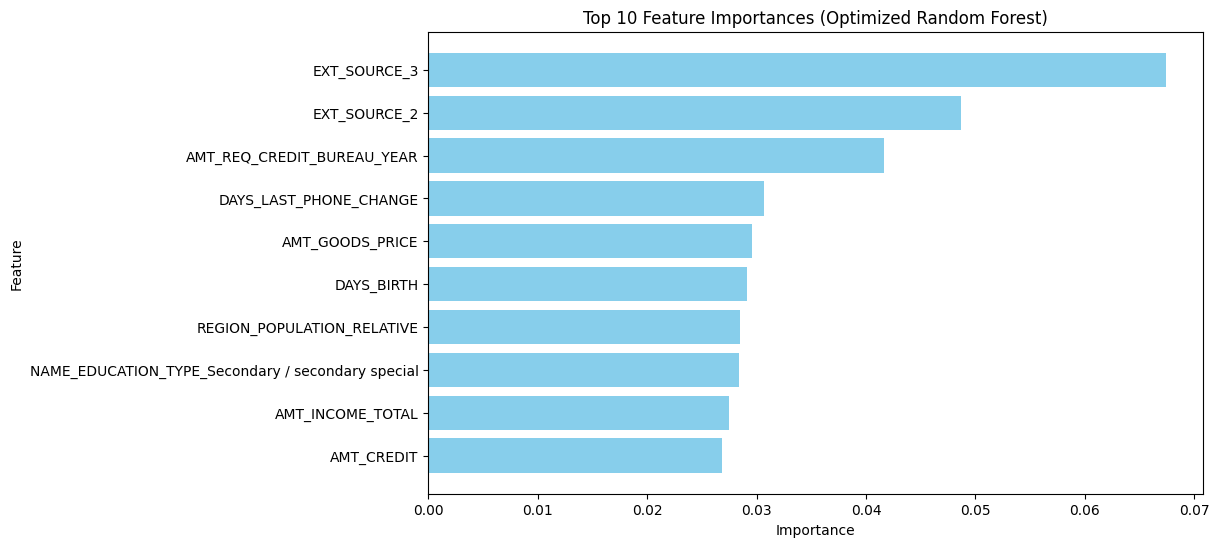

In [ ]:
# Retrieve feature importances from the optimized model
feature_importances = optimized_rf.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title('Top 10 Feature Importances (Optimized Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

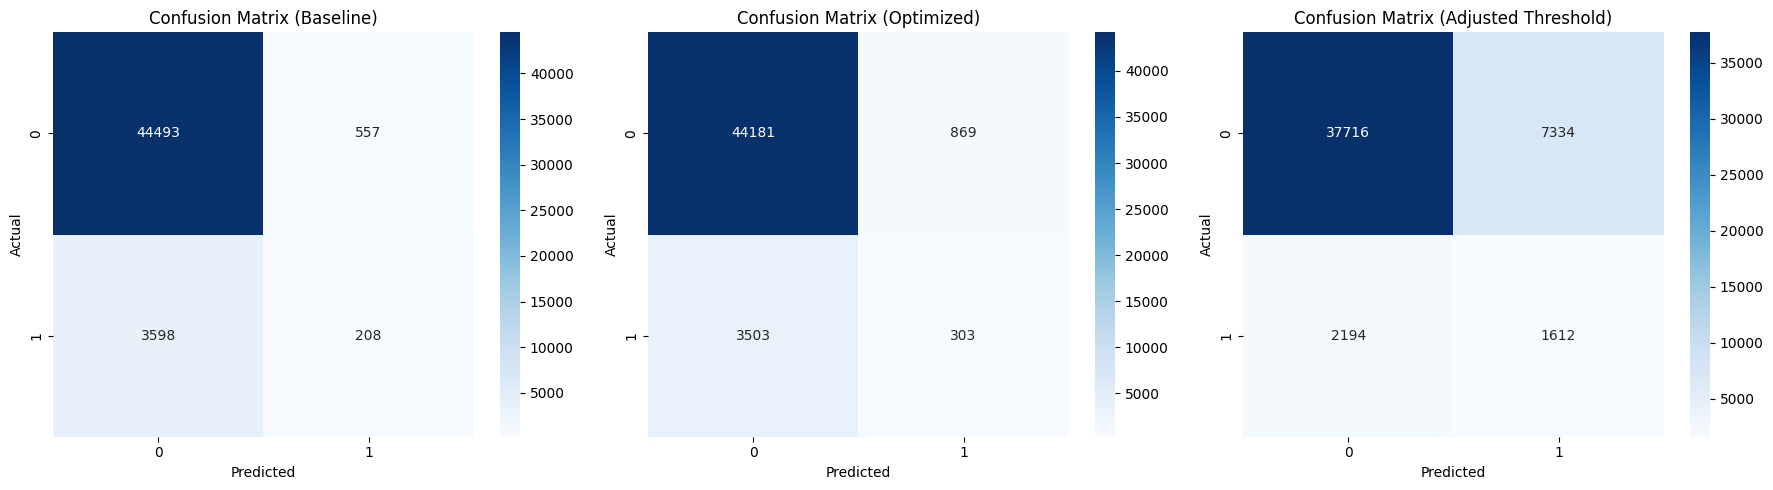

In [ ]:
# Display and compare confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['Baseline', 'Optimized', 'Adjusted Threshold']
conf_matrices = [conf_matrix_baseline, conf_matrix_optimized, conf_matrix_adjusted]

for i, ax in enumerate(axes):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix ({titles[i]})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
##try with feature engineering
def feature_engineering(data):
    data = data.copy()
    data["CREDIT_INCOME_RATIO"] = data["AMT_CREDIT"] / (data["AMT_INCOME_TOTAL"] + 1e-6)
    data["ANNUITY_INCOME_RATIO"] = data["AMT_ANNUITY"] / (data["AMT_INCOME_TOTAL"] + 1e-6)
    data["CREDIT_GOODS_RATIO"] = data["AMT_CREDIT"] / (data["AMT_GOODS_PRICE"] + 1e-6)
    data["ANNUITY_CREDIT_RATIO"] = data["AMT_ANNUITY"] / (data["AMT_CREDIT"] + 1e-6)
    data["CREDIT_TERM"] = data["AMT_CREDIT"] / (data["AMT_ANNUITY"] + 1e-6)
    data["AGE_YEARS"] = data["DAYS_BIRTH"] / -365.0
    data["EMPLOYMENT_LENGTH_YEARS"] = data["DAYS_EMPLOYED"] / -365.0
    data["INCOME_PER_PERSON"] = data["AMT_INCOME_TOTAL"] / (data["CNT_FAM_MEMBERS"] + 1e-6)
    data["AGE_EMPLOYMENT_RATIO"] = data["AGE_YEARS"] / (data["EMPLOYMENT_LENGTH_YEARS"] + 1e-6)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(0, inplace=True)
    return data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the dataset
df = encoded_application_clean.copy()

# Step 1: Drop unnecessary columns and prepare features and target
X = df.drop(columns=['TARGET'])
y = df['TARGET']  # Target variable

# Step 2: Apply feature engineering
X = feature_engineering(X)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Scale numerical columns only (leave binary columns unchanged)
scaler = StandardScaler()
binary_columns = X_train.columns[(X_train.nunique() == 2) & X_train.isin([0, 1]).all()]
numerical_columns = X_train.columns.difference(binary_columns)

# Apply scaling only to numerical columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Step 5: Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

# Train a baseline Random Forest model
baseline_rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
baseline_rf.fit(X_train_resampled, y_train_resampled)

# Evaluate the baseline model
y_pred_baseline = baseline_rf.predict(X_test)
y_pred_prob_baseline = baseline_rf.predict_proba(X_test)[:, 1]

# Print baseline evaluation metrics
print("Baseline Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_baseline):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

# Display confusion matrix
conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix (Baseline):")
print(conf_matrix_baseline)


Baseline Random Forest Performance:
Accuracy: 0.9138
ROC AUC Score: 0.7198

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.95     45050
           1       0.27      0.06      0.10      3806

    accuracy                           0.91     48856
   macro avg       0.60      0.52      0.53     48856
weighted avg       0.87      0.91      0.89     48856


Confusion Matrix (Baseline):
[[44403   647]
 [ 3565   241]]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define a subset of training data for faster tuning
subset_X_train, _, subset_y_train, _ = train_test_split(
    X_train_resampled, y_train_resampled,
    test_size=0.8,  # Use only 20% of training data
    stratify=y_train_resampled,  # Preserve class distribution
    random_state=42
)

# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'max_samples': [0.7, 0.8, None],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}],
}

# Perform randomized search with cross-validation
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search_rf.fit(subset_X_train, subset_y_train)

# Display the best parameters
print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best Parameters from RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': None, 'class_weight': {0: 1, 1: 2}, 'bootstrap': True}


In [ ]:
# Train the optimized Random Forest with the best parameters
best_params = random_search_rf.best_params_
optimized_rf = RandomForestClassifier(**best_params, random_state=42)
optimized_rf.fit(X_train_resampled, y_train_resampled)

# Evaluate the optimized model
y_pred_optimized = optimized_rf.predict(X_test)
y_pred_prob_optimized = optimized_rf.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized))

# Display confusion matrix
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
print("\nConfusion Matrix (Optimized):")
print(conf_matrix_optimized)


Optimized Random Forest Performance:
Accuracy: 0.9097
ROC AUC Score: 0.7143

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     45050
           1       0.25      0.08      0.12      3806

    accuracy                           0.91     48856
   macro avg       0.59      0.53      0.54     48856
weighted avg       0.87      0.91      0.89     48856


Confusion Matrix (Optimized):
[[44136   914]
 [ 3498   308]]


In [ ]:
# Adjust threshold
threshold = 0.3  # Experiment with different values
y_pred_adjusted = (y_pred_prob_optimized >= threshold).astype(int)

# Evaluate the adjusted model
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Display confusion matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
print("\nConfusion Matrix (Adjusted Threshold):")
print(conf_matrix_adjusted)


Performance with Adjusted Threshold:
Accuracy: 0.8009
ROC AUC Score: 0.7143

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.89     45050
           1       0.18      0.43      0.25      3806

    accuracy                           0.80     48856
   macro avg       0.56      0.63      0.57     48856
weighted avg       0.89      0.80      0.84     48856


Confusion Matrix (Adjusted Threshold):
[[37508  7542]
 [ 2184  1622]]



Top 10 Most Important Features:
                                               Feature  Importance
30                                        EXT_SOURCE_3    0.056659
29                                        EXT_SOURCE_2    0.040148
61                          AMT_REQ_CREDIT_BUREAU_YEAR    0.033639
84   NAME_EDUCATION_TYPE_Secondary / secondary special    0.030234
35                              DAYS_LAST_PHONE_CHANGE    0.025189
162                                 CREDIT_GOODS_RATIO    0.024786
164                                        CREDIT_TERM    0.023249
8                           REGION_POPULATION_RELATIVE    0.022757
168                               AGE_EMPLOYMENT_RATIO    0.022417
163                               ANNUITY_CREDIT_RATIO    0.022094


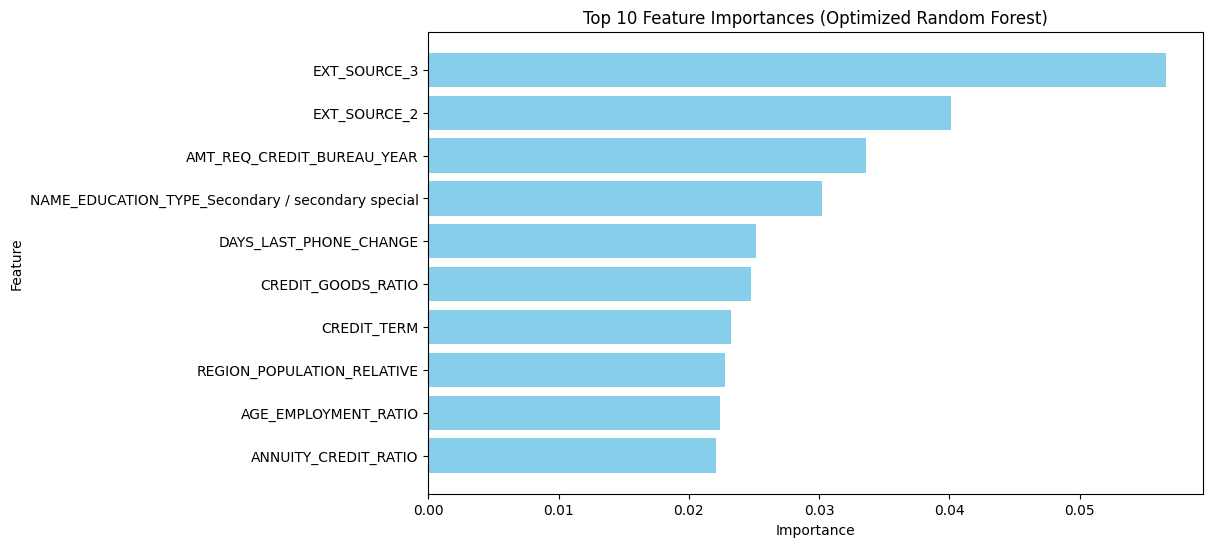

In [ ]:
# Retrieve feature importances from the optimized model
feature_importances = optimized_rf.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title('Top 10 Feature Importances (Optimized Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


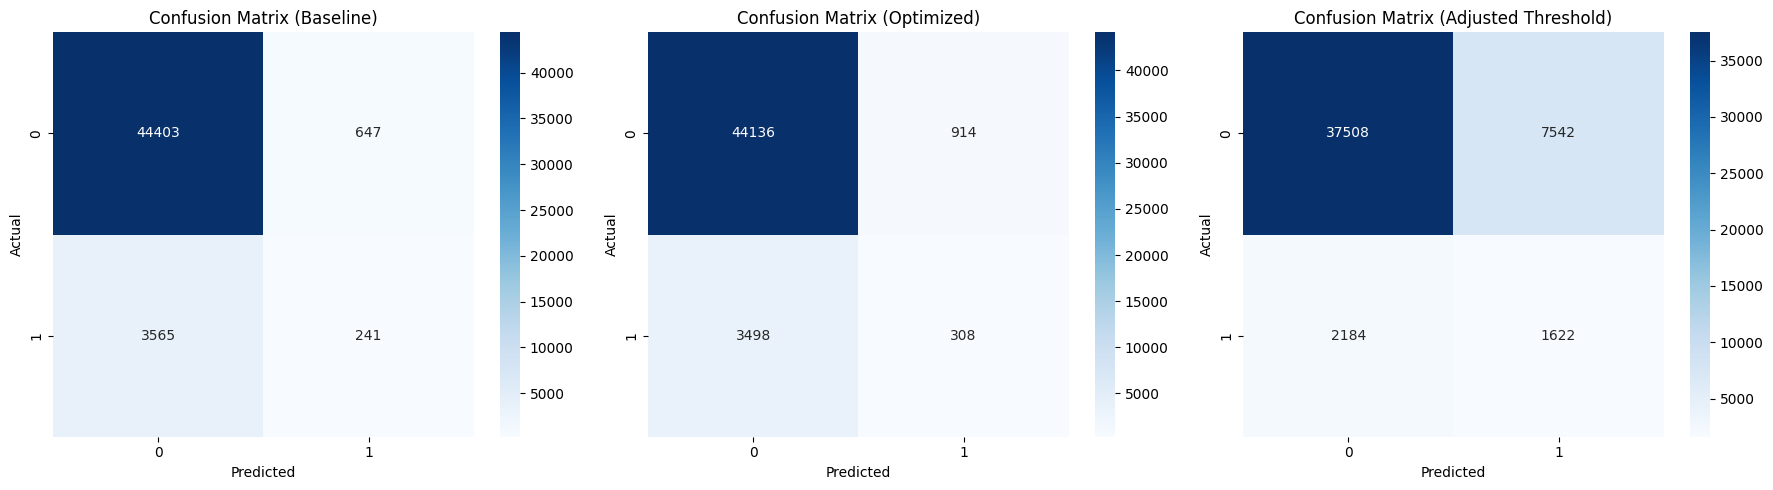

In [ ]:
# Display and compare confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['Baseline', 'Optimized', 'Adjusted Threshold']
conf_matrices = [conf_matrix_baseline, conf_matrix_optimized, conf_matrix_adjusted]

for i, ax in enumerate(axes):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix ({titles[i]})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [ ]:
##Full Code: PCA Random Forest Without Feature Engineering

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Load dataset
df = encoded_application_clean.copy()
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical columns
scaler = StandardScaler()
binary_columns = X_train.columns[(X_train.nunique() == 2) & X_train.isin([0, 1]).all()]
numerical_columns = X_train.columns.difference(binary_columns)

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Apply PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

print(f"Number of PCA components retained: {X_train_pca.shape[1]}")

Number of PCA components retained: 45


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

# Subset training data for faster tuning
subset_X_train, _, subset_y_train, _ = train_test_split(
    X_train_pca, y_train_resampled,
    test_size=0.8,  # Use only 20% of the training data for tuning
    stratify=y_train_resampled,  # Maintain class distribution
    random_state=42
)

# Parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}]
}

# Perform Randomized Search with Cross-Validation
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=30,  # Number of random combinations to try
    scoring='f1',  # Optimize for F1 Score
    cv=3,  # 3-fold cross-validation
    random_state=42,
    n_jobs=-1,  # Use all available CPUs
    verbose=2  # Display progress
)

# Fit RandomizedSearchCV on the subset
random_search_rf.fit(subset_X_train, subset_y_train)

# Display the best parameters
print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best Parameters from RandomizedSearchCV:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'class_weight': {0: 1, 1: 3}}


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score

# Train Optimized Random Forest
best_params = random_search_rf.best_params_
optimized_rf = RandomForestClassifier(**best_params, random_state=42)
optimized_rf.fit(X_train_pca, y_train_resampled)

# Evaluate Optimized Model
y_pred_optimized = optimized_rf.predict(X_test_pca)
y_pred_prob_optimized = optimized_rf.predict_proba(X_test_pca)[:, 1]

print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_optimized):.4f}")
print(f"Precision-Recall AUC Score: {average_precision_score(y_test, y_pred_prob_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized))


Optimized Random Forest Performance:
Accuracy: 0.8768
ROC AUC Score: 0.6902
Precision-Recall AUC Score: 0.1561

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     45050
           1       0.20      0.19      0.20      3806

    accuracy                           0.88     48856
   macro avg       0.57      0.56      0.56     48856
weighted avg       0.87      0.88      0.88     48856



Adjusted Threshold: 0.3

Performance with Adjusted Threshold:
Accuracy: 0.7129
ROC AUC Score: 0.6902

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.95      0.73      0.82     45050
           1       0.14      0.54      0.23      3806

    accuracy                           0.71     48856
   macro avg       0.55      0.64      0.53     48856
weighted avg       0.89      0.71      0.78     48856


Confusion Matrix (Adjusted Threshold):
[[32754 12296]
 [ 1732  2074]]


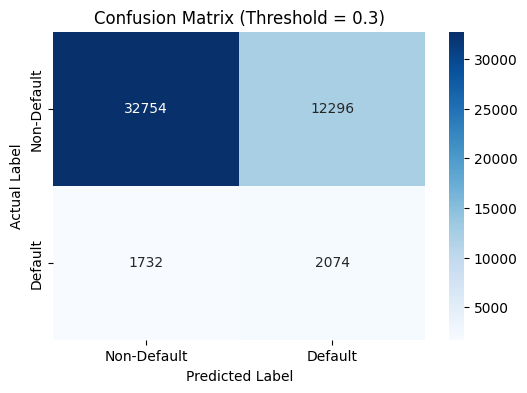

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Adjust predictions based on threshold 0.3
threshold = 0.3
y_pred_adjusted = (y_pred_prob_optimized >= threshold).astype(int)

# Evaluate the model with adjusted threshold
print(f"Adjusted Threshold: {threshold}")
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_optimized):.4f}")
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
print("\nConfusion Matrix (Adjusted Threshold):")
print(conf_matrix_adjusted)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

Adjusted Threshold: 0.37

Performance with Adjusted Threshold:
Accuracy: 0.7968
ROC AUC Score: 0.6902

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     45050
           1       0.17      0.40      0.23      3806

    accuracy                           0.80     48856
   macro avg       0.55      0.61      0.56     48856
weighted avg       0.88      0.80      0.83     48856


Confusion Matrix (Adjusted Threshold):
[[37422  7628]
 [ 2298  1508]]


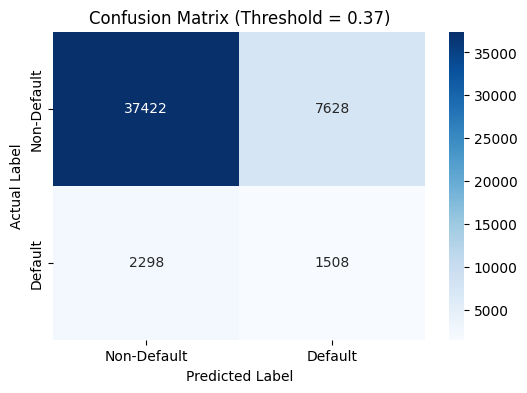

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Adjust predictions based on threshold 0.3
threshold = 0.37
y_pred_adjusted = (y_pred_prob_optimized >= threshold).astype(int)

# Evaluate the model with adjusted threshold
print(f"Adjusted Threshold: {threshold}")
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_optimized):.4f}")
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
print("\nConfusion Matrix (Adjusted Threshold):")
print(conf_matrix_adjusted)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()


Top 10 Most Important Features:
   Feature  Importance
38  PCA_39    0.052760
8    PCA_9    0.047375
0    PCA_1    0.045862
25  PCA_26    0.043299
36  PCA_37    0.039794
34  PCA_35    0.037729
5    PCA_6    0.034072
37  PCA_38    0.032560
23  PCA_24    0.025965
39  PCA_40    0.025503


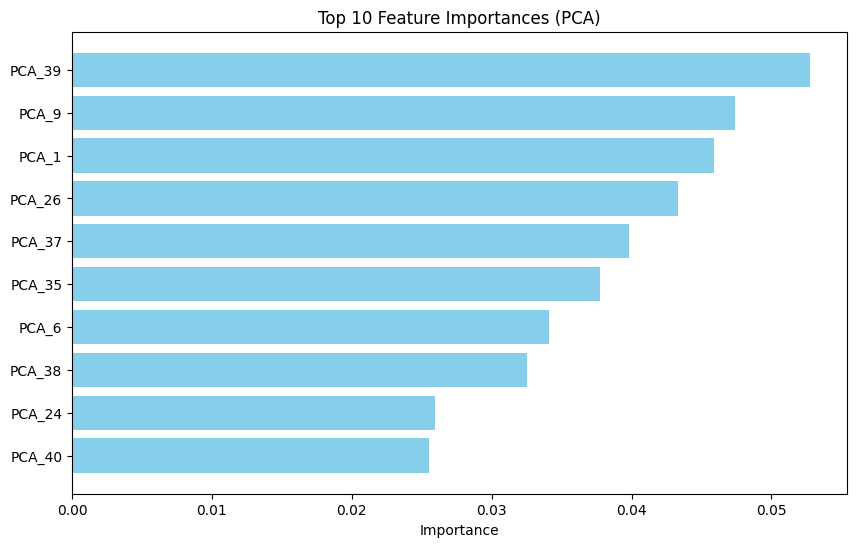

In [ ]:
# Feature Importance Analysis
feature_importances = optimized_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': [f'PCA_{i+1}' for i in range(len(feature_importances))],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances (PCA)')
plt.xlabel('Importance')
plt.show()

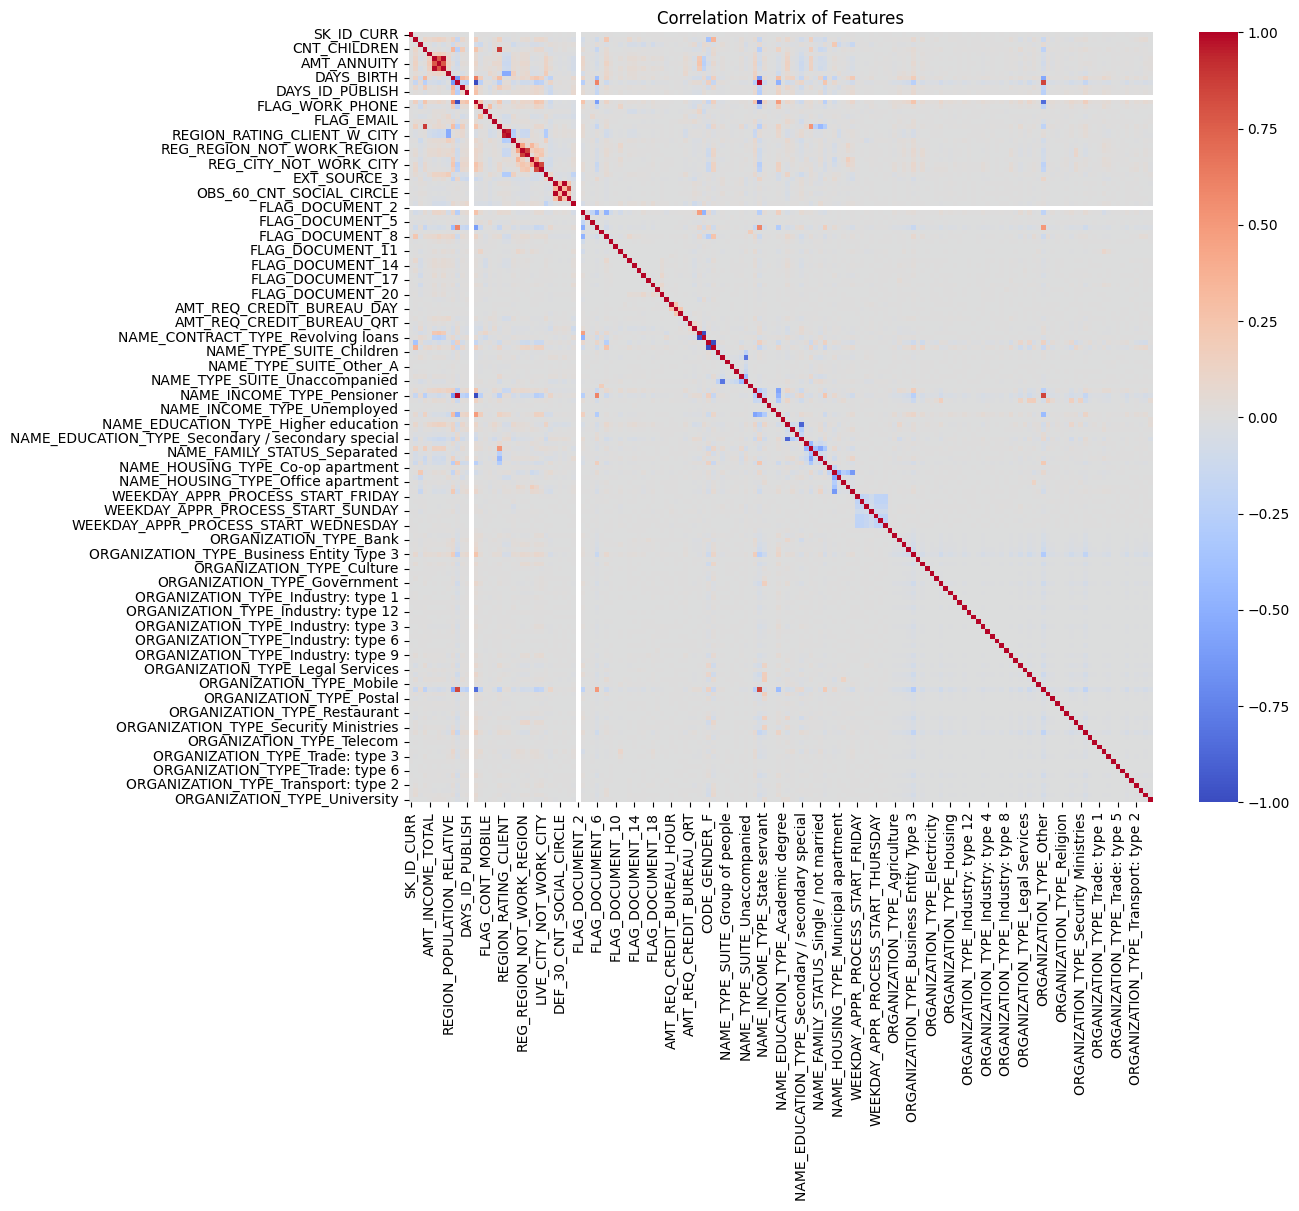

In [ ]:
# Correlation matrix for the original features
corr_matrix = X.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


In [ ]:
##PCA random forest with feautre enineering

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Feature Engineering Function
def feature_engineering(data):
    data = data.copy()
    data["CREDIT_INCOME_RATIO"] = data["AMT_CREDIT"] / (data["AMT_INCOME_TOTAL"] + 1e-6)
    data["ANNUITY_INCOME_RATIO"] = data["AMT_ANNUITY"] / (data["AMT_INCOME_TOTAL"] + 1e-6)
    data["CREDIT_GOODS_RATIO"] = data["AMT_CREDIT"] / (data["AMT_GOODS_PRICE"] + 1e-6)
    data["ANNUITY_CREDIT_RATIO"] = data["AMT_ANNUITY"] / (data["AMT_CREDIT"] + 1e-6)
    data["CREDIT_TERM"] = data["AMT_CREDIT"] / (data["AMT_ANNUITY"] + 1e-6)
    data["AGE_YEARS"] = data["DAYS_BIRTH"] / -365.0
    data["EMPLOYMENT_LENGTH_YEARS"] = data["DAYS_EMPLOYED"] / -365.0
    data["INCOME_PER_PERSON"] = data["AMT_INCOME_TOTAL"] / (data["CNT_FAM_MEMBERS"] + 1e-6)
    data["AGE_EMPLOYMENT_RATIO"] = data["AGE_YEARS"] / (data["EMPLOYMENT_LENGTH_YEARS"] + 1e-6)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(0, inplace=True)
    return data

# Load dataset
df = encoded_application_clean.copy()
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Apply Feature Engineering
X = feature_engineering(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical columns
scaler = StandardScaler()
binary_columns = X_train.columns[(X_train.nunique() == 2) & X_train.isin([0, 1]).all()]
numerical_columns = X_train.columns.difference(binary_columns)

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

print(f"Number of PCA components retained: {X_train_pca.shape[1]}")

Number of PCA components retained: 45


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

# Train Baseline Random Forest
baseline_rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
baseline_rf.fit(X_train_pca, y_train_resampled)

# Evaluate Baseline Model
y_pred_baseline = baseline_rf.predict(X_test_pca)
y_pred_prob_baseline = baseline_rf.predict_proba(X_test_pca)[:, 1]

print("\nBaseline Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_baseline):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))


Baseline Random Forest Performance:
Accuracy: 0.8992
ROC AUC Score: 0.6871

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     45050
           1       0.22      0.12      0.16      3806

    accuracy                           0.90     48856
   macro avg       0.58      0.54      0.55     48856
weighted avg       0.87      0.90      0.88     48856



In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

# Subset training data for faster tuning
subset_X_train, _, subset_y_train, _ = train_test_split(
    X_train_pca, y_train_resampled,
    test_size=0.8,  # Use only 20% of the training data
    stratify=y_train_resampled,
    random_state=42
)

# Parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}]
}

# Perform Randomized Search
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=30,  # 30 random candidates
    scoring='f1',
    cv=3,  # 3-fold cross-validation
    random_state=42,
    n_jobs=-1,  # Use all available CPUs
    verbose=2
)

# Fit RandomizedSearchCV on the subset
random_search_rf.fit(subset_X_train, subset_y_train)

# Display the best parameters
print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best Parameters from RandomizedSearchCV:
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': {0: 1, 1: 2}}


In [ ]:
# Train Optimized Random Forest
best_params = random_search_rf.best_params_
optimized_rf = RandomForestClassifier(**best_params, random_state=42)
optimized_rf.fit(X_train_pca, y_train_resampled)

# Evaluate Optimized Model
y_pred_optimized = optimized_rf.predict(X_test_pca)
y_pred_prob_optimized = optimized_rf.predict_proba(X_test_pca)[:, 1]

print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized))


Optimized Random Forest Performance:
Accuracy: 0.9011
ROC AUC Score: 0.6898

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     45050
           1       0.23      0.12      0.15      3806

    accuracy                           0.90     48856
   macro avg       0.58      0.54      0.55     48856
weighted avg       0.87      0.90      0.89     48856



In [ ]:
# Adjust Threshold to 0.3
threshold = 0.35
y_pred_adjusted = (y_pred_prob_optimized >= threshold).astype(int)

# Evaluate Adjusted Model
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
print("\nConfusion Matrix (Adjusted Threshold):")
print(conf_matrix_adjusted)


Performance with Adjusted Threshold:
Accuracy: 0.8224
ROC AUC Score: 0.6898

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     45050
           1       0.17      0.33      0.23      3806

    accuracy                           0.82     48856
   macro avg       0.56      0.60      0.56     48856
weighted avg       0.88      0.82      0.85     48856


Confusion Matrix (Adjusted Threshold):
[[38910  6140]
 [ 2536  1270]]



Top 10 Most Important Features:
   Feature  Importance
29  PCA_30    0.060107
41  PCA_42    0.059641
39  PCA_40    0.038250
0    PCA_1    0.035600
10  PCA_11    0.033683
33  PCA_34    0.032351
37  PCA_38    0.030033
9   PCA_10    0.029607
40  PCA_41    0.029150
42  PCA_43    0.028848


C:\Users\ruoxi\AppData\Local\Temp\ipykernel_14172\3011653429.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'].head(10), y=importance_df['Feature'].head(10), palette='coolwarm')


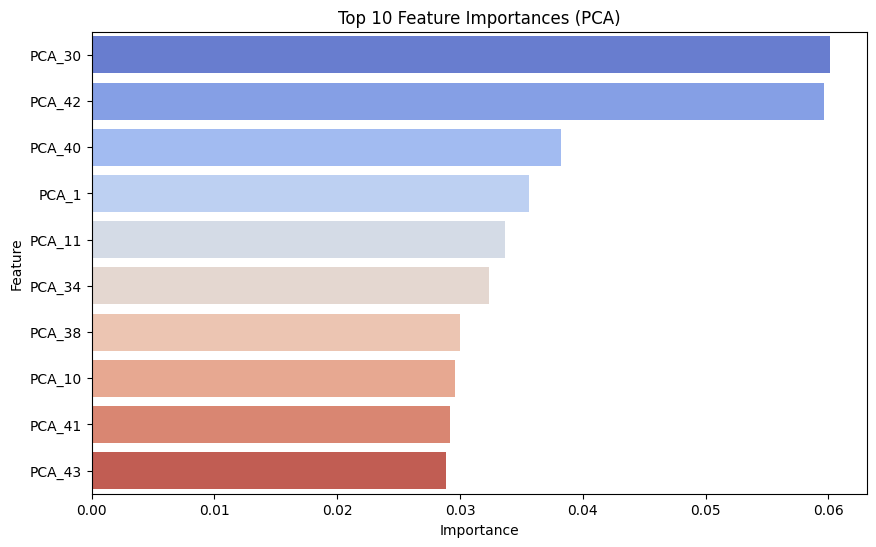

In [ ]:
# Feature Importance Analysis
feature_importances = optimized_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': [f'PCA_{i+1}' for i in range(len(feature_importances))],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'].head(10), y=importance_df['Feature'].head(10), palette='coolwarm')
plt.title('Top 10 Feature Importances (PCA)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

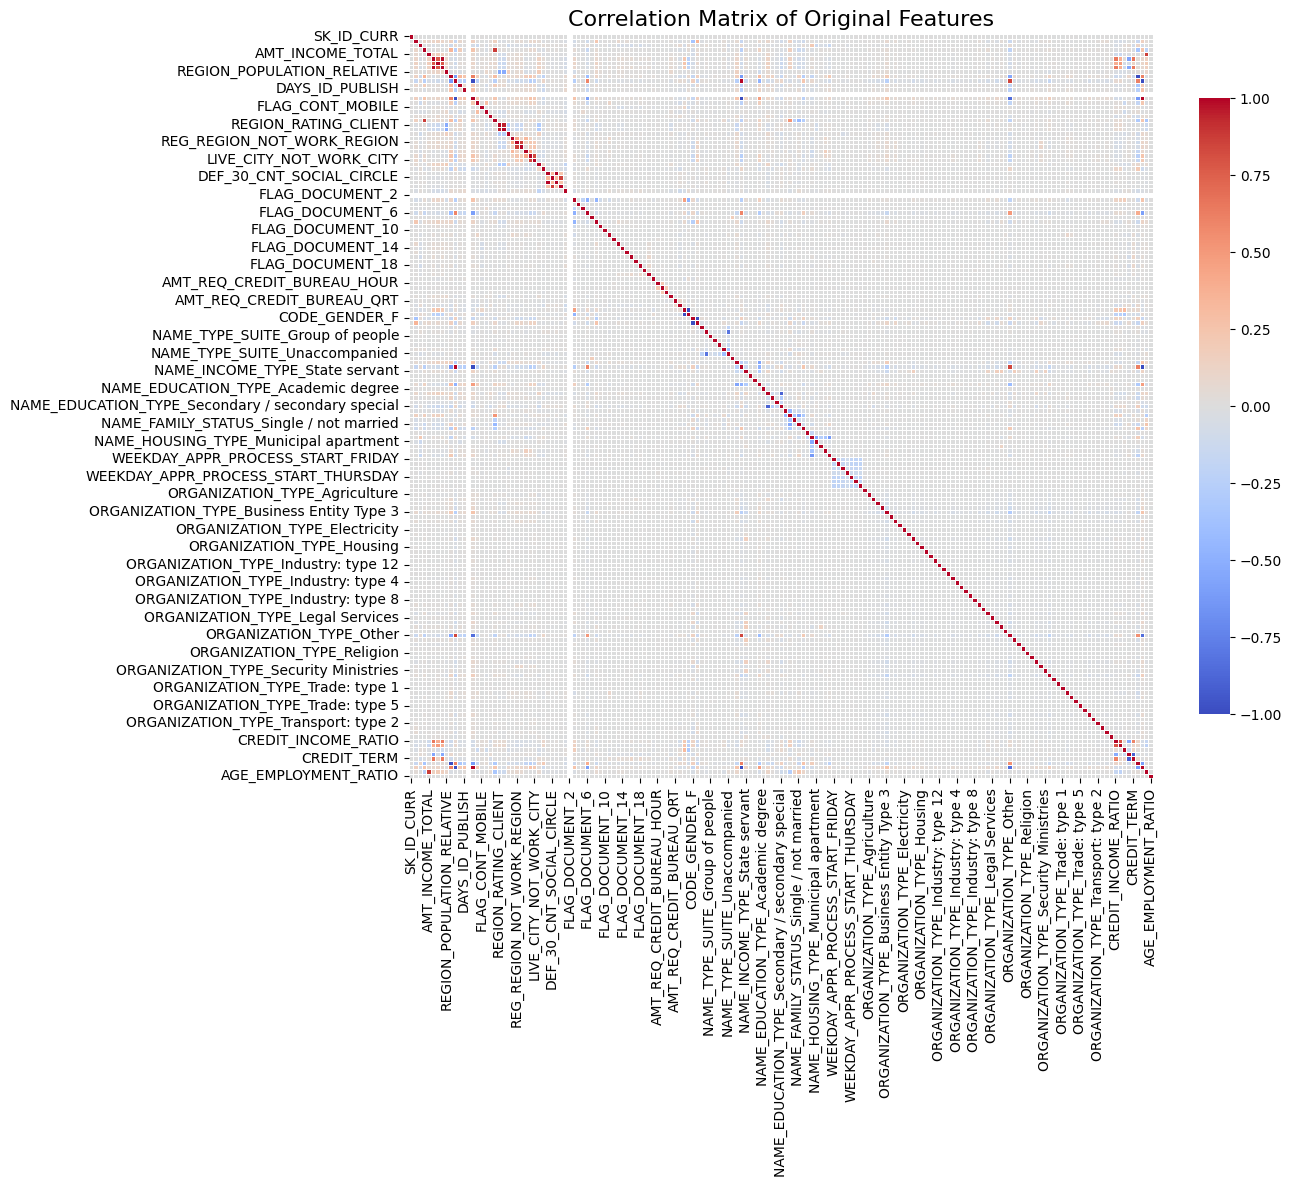

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix for original features
correlation_matrix = X.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", square=True, 
            cbar_kws={'shrink': 0.8}, linewidths=0.5)

plt.title('Correlation Matrix of Original Features', fontsize=16)
plt.show()


In [ ]:
##Bagging with bagged tree

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = encoded_application_clean.copy()

# Separate features and target
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Feature Engineering Function
def feature_engineering(data):
    data = data.copy()
    data["CREDIT_INCOME_RATIO"] = data["AMT_CREDIT"] / (data["AMT_INCOME_TOTAL"] + 1e-6)
    data["ANNUITY_INCOME_RATIO"] = data["AMT_ANNUITY"] / (data["AMT_INCOME_TOTAL"] + 1e-6)
    data["CREDIT_GOODS_RATIO"] = data["AMT_CREDIT"] / (data["AMT_GOODS_PRICE"] + 1e-6)
    data["ANNUITY_CREDIT_RATIO"] = data["AMT_ANNUITY"] / (data["AMT_CREDIT"] + 1e-6)
    data["CREDIT_TERM"] = data["AMT_CREDIT"] / (data["AMT_ANNUITY"] + 1e-6)
    data["AGE_YEARS"] = data["DAYS_BIRTH"] / -365.0
    data["EMPLOYMENT_LENGTH_YEARS"] = data["DAYS_EMPLOYED"] / -365.0
    data["INCOME_PER_PERSON"] = data["AMT_INCOME_TOTAL"] / (data["CNT_FAM_MEMBERS"] + 1e-6)
    data["AGE_EMPLOYMENT_RATIO"] = data["AGE_YEARS"] / (data["EMPLOYMENT_LENGTH_YEARS"] + 1e-6)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(0, inplace=True)
    return data

# Apply Feature Engineering
X = feature_engineering(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [34]:
from imblearn.over_sampling import SMOTE

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts())



Class distribution after resampling:
TARGET
0    180194
1    180194
Name: count, dtype: int64


In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, accuracy_score
)

# Initialize Baseline Bagging Classifier
baseline_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    n_estimators=50,  # Number of trees
    random_state=42,
    n_jobs=-1
)

# Train Baseline Bagging Classifier
baseline_bagging.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_baseline = baseline_bagging.predict(X_test)
y_pred_proba_baseline = baseline_bagging.predict_proba(X_test)[:, 1]

# Evaluate Baseline Performance
print("\nBaseline Bagging Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))



Baseline Bagging Classifier Performance:
Accuracy: 0.9197
ROC AUC Score: 0.6937

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     45050
           1       0.32      0.03      0.05      3806

    accuracy                           0.92     48856
   macro avg       0.62      0.51      0.50     48856
weighted avg       0.88      0.92      0.89     48856



In [36]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define a simplified parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_samples': [0.8, 1.0],
    'max_features': [0.8, 1.0],
    'bootstrap': [True],
    'estimator__max_depth': [10, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

# Initialize Bagging Classifier with DecisionTreeClassifier
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    random_state=42,
    n_jobs=-1
)

# Subset the training data for faster tuning
subset_X_train, _, subset_y_train, _ = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.8, random_state=42, stratify=y_train_resampled
)

# RandomizedSearchCV with reduced candidates and folds
random_search = RandomizedSearchCV(
    estimator=bagging_clf,
    param_distributions=param_grid,
    n_iter=30, 
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(subset_X_train, subset_y_train)

# Best Parameters
best_params = random_search.best_params_
print("\nBest Parameters from RandomizedSearchCV:")
print(best_params)





Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\ruoxi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Parameters from RandomizedSearchCV:
{'n_estimators': 100, 'max_samples': 0.8, 'max_features': 0.8, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': None, 'bootstrap': True}


In [37]:
# Extract parameters for DecisionTreeClassifier
tree_params = {
    key.split('__')[1]: value for key, value in best_params.items() if key.startswith('estimator__')
}

# Parameters for BaggingClassifier
bagging_params = {
    key: value for key, value in best_params.items() if not key.startswith('estimator__')
}

# Define the base estimator with best parameters
base_estimator = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    **tree_params
)

# Initialize optimized Bagging Classifier
optimized_bagging = BaggingClassifier(
    estimator=base_estimator,
    random_state=42,
    n_jobs=-1,
    **bagging_params
)

# Train the optimized Bagging Classifier
optimized_bagging.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_optimized = optimized_bagging.predict(X_test)
y_pred_proba_optimized = optimized_bagging.predict_proba(X_test)[:, 1]

# Evaluate Optimized Performance
print("\nOptimized Bagging Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized))



Optimized Bagging Classifier Performance:
Accuracy: 0.9213
ROC AUC Score: 0.7182

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     45050
           1       0.39      0.02      0.03      3806

    accuracy                           0.92     48856
   macro avg       0.66      0.51      0.50     48856
weighted avg       0.88      0.92      0.89     48856




Performance with Adjusted Threshold:
Accuracy: 0.8826
ROC AUC Score: 0.7182

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     45050
           1       0.25      0.25      0.25      3806

    accuracy                           0.88     48856
   macro avg       0.59      0.59      0.59     48856
weighted avg       0.88      0.88      0.88     48856



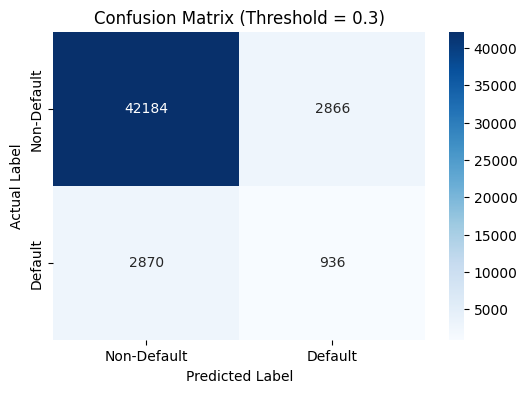

In [38]:
# Adjust Threshold
threshold = 0.3  # Adjust based on desired sensitivity
y_pred_adjusted = (y_pred_proba_optimized >= threshold).astype(int)

# Evaluate Performance with Adjusted Threshold
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()



Performance with Adjusted Threshold:
Accuracy: 0.7650
ROC AUC Score: 0.7182

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     45050
           1       0.17      0.52      0.26      3806

    accuracy                           0.77     48856
   macro avg       0.56      0.65      0.56     48856
weighted avg       0.89      0.77      0.81     48856



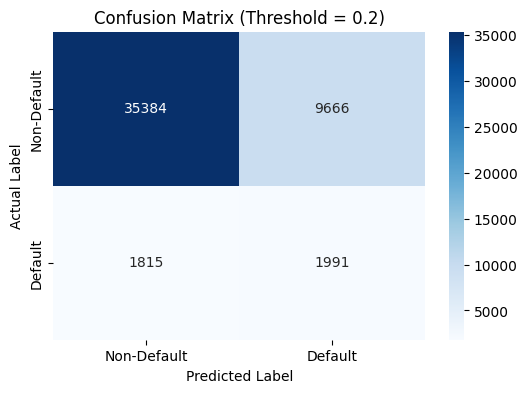

In [39]:
# Adjust Threshold
threshold = 0.2  # Adjust based on desired sensitivity
y_pred_adjusted = (y_pred_proba_optimized >= threshold).astype(int)

# Evaluate Performance with Adjusted Threshold
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()


Top 10 Most Important Features (Permutation Importance):
                                               Feature  Importance
84   NAME_EDUCATION_TYPE_Secondary / secondary special    0.103905
65                                       CODE_GENDER_M    0.083398
30                                        EXT_SOURCE_3    0.064202
81                NAME_EDUCATION_TYPE_Higher education    0.061017
79                            NAME_INCOME_TYPE_Working    0.060587
64                                       CODE_GENDER_F    0.042812
29                                        EXT_SOURCE_2    0.036939
108           ORGANIZATION_TYPE_Business Entity Type 3    0.035715
102               WEEKDAY_APPR_PROCESS_START_WEDNESDAY    0.031037
74               NAME_INCOME_TYPE_Commercial associate    0.025711


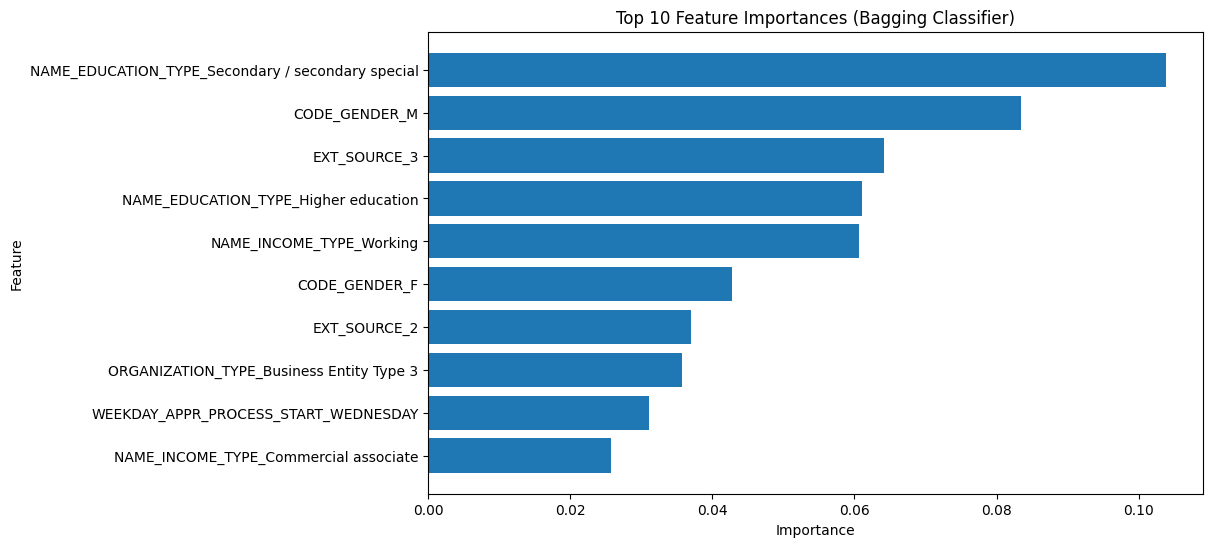

In [40]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Subset the test dataset (e.g., take 20% of data for quicker computation)
X_test_subset = X_test.sample(frac=0.2, random_state=42)
y_test_subset = y_test.loc[X_test_subset.index]

# Compute permutation importance with fewer repeats and subset data
perm_importance = permutation_importance(
    optimized_bagging,
    X_test_subset,
    y_test_subset,
    scoring='roc_auc',
    n_repeats=5,  # Reduced from 10 to 5
    random_state=42,
    n_jobs=-1
)

# Create Feature Importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display Top 10 Features
print("\nTop 10 Most Important Features (Permutation Importance):")
print(feature_importance_df.head(10))

# Plot Top 10 Features
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['Feature'].head(10)[::-1],  # Reverse for better visualization
    feature_importance_df['Importance'].head(10)[::-1]
)
plt.title('Top 10 Feature Importances (Bagging Classifier)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [41]:
##bagging with PCA

In [42]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Step 1: Prepare features and target
df = encoded_application_clean.copy()
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Scale numerical columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Apply PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 5: Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print(f"PCA Reduced Training Shape: {X_train_resampled.shape}")
print(f"PCA Reduced Testing Shape: {X_test_pca.shape}")


PCA Reduced Training Shape: (360388, 126)
PCA Reduced Testing Shape: (48856, 126)


In [43]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, accuracy_score
)

# Initialize baseline Bagging Classifier
baseline_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

# Train Baseline Bagging Classifier
baseline_bagging.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_baseline = baseline_bagging.predict(X_test_pca)
y_pred_proba_baseline = baseline_bagging.predict_proba(X_test_pca)[:, 1]

# Evaluate Baseline Performance
print("\nBaseline Bagging Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))



Baseline Bagging Classifier Performance:
Accuracy: 0.8775
ROC AUC Score: 0.6785

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     45050
           1       0.19      0.18      0.19      3806

    accuracy                           0.88     48856
   macro avg       0.56      0.56      0.56     48856
weighted avg       0.87      0.88      0.88     48856



In [44]:
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'estimator__max_depth': [5, 10, 15, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_samples': [0.8, 1.0],
}

# Subset for hyperparameter tuning
subset_X_train, _, subset_y_train, _ = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.8, random_state=42, stratify=y_train_resampled
)

# Randomized Search
random_search_bagging = RandomizedSearchCV(
    estimator=BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        random_state=42
    ),
    param_distributions=param_grid,
    n_iter=15,  # Adjust for faster execution
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search_bagging.fit(subset_X_train, subset_y_train)

# Display best parameters
print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_bagging.best_params_)




Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters from RandomizedSearchCV:
{'n_estimators': 50, 'max_samples': 0.8, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': None, 'bootstrap': False}



Optimized Bagging Classifier Performance:
Accuracy: 0.8793
ROC AUC Score: 0.6722

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     45050
           1       0.19      0.17      0.18      3806

    accuracy                           0.88     48856
   macro avg       0.56      0.55      0.56     48856
weighted avg       0.87      0.88      0.88     48856


Confusion Matrix:
[[42322  2728]
 [ 3167   639]]


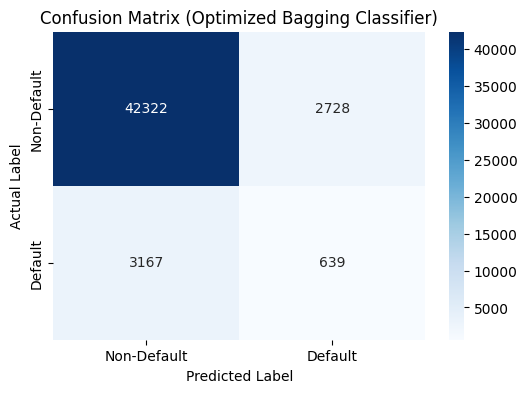

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Extract parameters for DecisionTreeClassifier from the best_params
best_params = random_search_bagging.best_params_

tree_params = {
    key.split('__')[1]: value for key, value in best_params.items() if key.startswith('estimator__')
}

# Extract parameters for BaggingClassifier
bagging_params = {
    key: value for key, value in best_params.items() if not key.startswith('estimator__')
}

# Define the base estimator using the tuned parameters
base_estimator = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    **tree_params
)

# Define the optimized Bagging Classifier
optimized_bagging = BaggingClassifier(
    estimator=base_estimator,
    random_state=42,
    n_jobs=-1,
    **bagging_params
)

# Train the optimized Bagging Classifier
optimized_bagging.fit(X_train_resampled, y_train_resampled)

# Predict on the test set using PCA-transformed data
y_pred_optimized = optimized_bagging.predict(X_test_pca)
y_pred_proba_optimized = optimized_bagging.predict_proba(X_test_pca)[:, 1]

# Evaluate Optimized Performance
print("\nOptimized Bagging Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_optimized)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix (Optimized Bagging Classifier)')
plt.show()





Performance with Adjusted Threshold:
Accuracy: 0.6994
ROC AUC Score: 0.6722

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81     45050
           1       0.14      0.53      0.22      3806

    accuracy                           0.70     48856
   macro avg       0.54      0.62      0.51     48856
weighted avg       0.88      0.70      0.77     48856



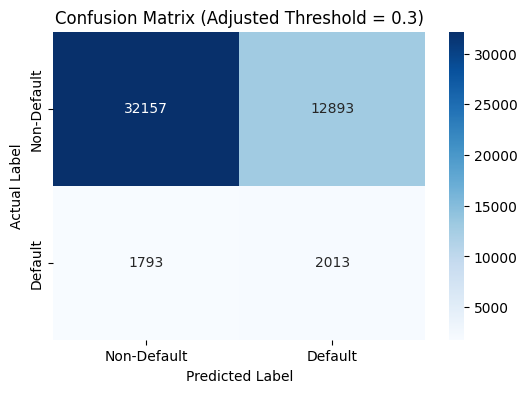

In [ ]:
# Adjust Threshold
threshold = 0.3
y_pred_adjusted = (optimized_bagging.predict_proba(X_test_pca)[:, 1] >= threshold).astype(int)

# Evaluate Performance with Adjusted Threshold
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, optimized_bagging.predict_proba(X_test_pca)[:, 1]):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix (Adjusted Threshold = {threshold})')
plt.show()




Performance with Adjusted Threshold:
Accuracy: 0.7698
ROC AUC Score: 0.6722

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86     45050
           1       0.15      0.42      0.22      3806

    accuracy                           0.77     48856
   macro avg       0.55      0.61      0.54     48856
weighted avg       0.88      0.77      0.81     48856



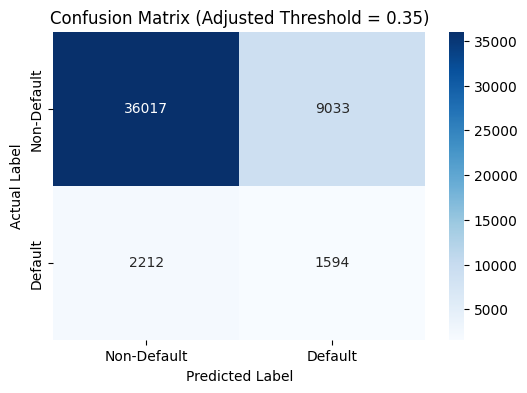

In [50]:
# Adjust Threshold
threshold = 0.35
y_pred_adjusted = (optimized_bagging.predict_proba(X_test_pca)[:, 1] >= threshold).astype(int)

# Evaluate Performance with Adjusted Threshold
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, optimized_bagging.predict_proba(X_test_pca)[:, 1]):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix (Adjusted Threshold = {threshold})')
plt.show()


Performance with Adjusted Threshold:
Accuracy: 0.7806
ROC AUC Score: 0.6722

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     45050
           1       0.15      0.40      0.22      3806

    accuracy                           0.78     48856
   macro avg       0.55      0.61      0.55     48856
weighted avg       0.88      0.78      0.82     48856



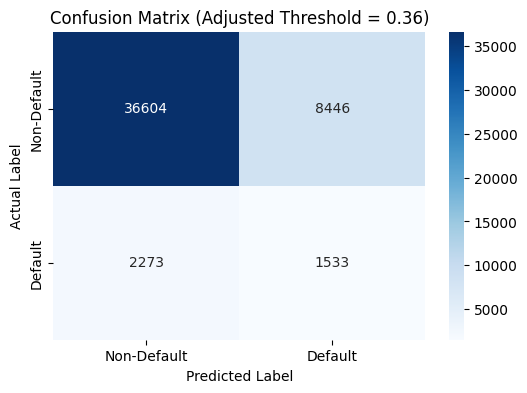

In [52]:
# Adjust Threshold
threshold = 0.36
y_pred_adjusted = (optimized_bagging.predict_proba(X_test_pca)[:, 1] >= threshold).astype(int)

# Evaluate Performance with Adjusted Threshold
print("\nPerformance with Adjusted Threshold:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, optimized_bagging.predict_proba(X_test_pca)[:, 1]):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix (Adjusted Threshold = {threshold})')
plt.show()


Top 10 Most Important PCA Components (Permutation Importance):
   PCA Component  Importance
1          PCA_2    0.035285
0          PCA_1    0.024646
4          PCA_5    0.012677
11        PCA_12    0.012440
10        PCA_11    0.006211
20        PCA_21    0.005808
82        PCA_83    0.005364
38        PCA_39    0.004978
29        PCA_30    0.004099
15        PCA_16    0.004066


C:\Users\ruoxi\AppData\Local\Temp\ipykernel_27752\1452625887.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


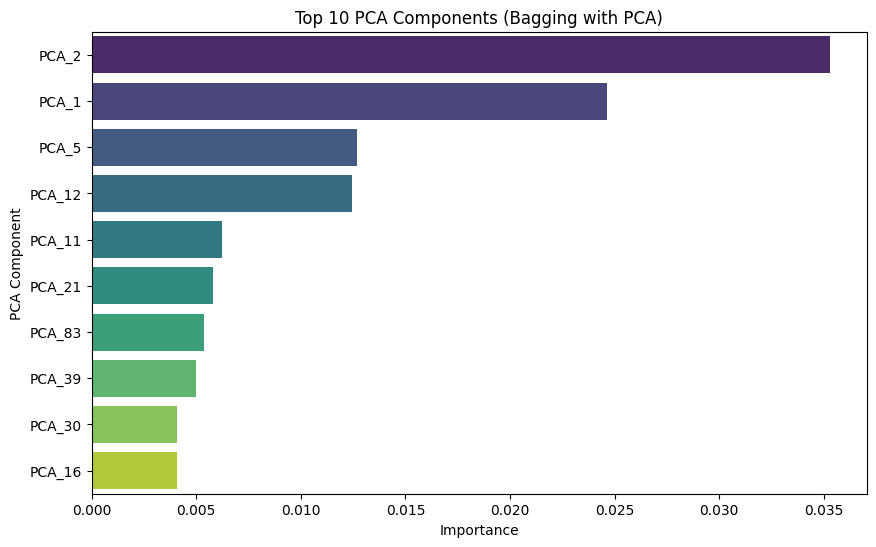

In [47]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(
    optimized_bagging,
    X_test_pca,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create Feature Importance DataFrame
importance_df = pd.DataFrame({
    'PCA Component': [f'PCA_{i+1}' for i in range(X_test_pca.shape[1])],
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display Top 10 PCA Components
print("\nTop 10 Most Important PCA Components (Permutation Importance):")
print(importance_df.head(10))

# Plot Top 10 PCA Components
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='PCA Component',
    data=importance_df.head(10),
    palette='viridis'
)
plt.title('Top 10 PCA Components (Bagging with PCA)')
plt.xlabel('Importance')
plt.ylabel('PCA Component')
plt.show()



In [ ]:
## final

### previous_application.csv - ignore for now

In [48]:
#df_previous_application = pd.read_csv('previous_application.csv')
#df_previous_application.head()

In [49]:
#df_previous_application[df_previous_application['SK_ID_CURR']==100003]